## Getting the keys and installation

1. In order to get trial keys for Spark NLP for Healthcare
, fill the form at https://www.johnsnowlabs.com/spark-nlp-try-free/ and you will get your keys to your email in a few minutes.

2. On a new cluster or existing one

  - add the following to the `Advanced Options -> Spark` tab, in `Spark.Config` box:

    ```bash
    spark.local.dir /var
    spark.kryoserializer.buffer.max 1000M
    spark.serializer org.apache.spark.serializer.KryoSerializer
    ```
  - add the following to the `Advanced Options -> Spark` tab, in `Environment Variables` box:

    ```bash
    AWS_ACCESS_KEY_ID=xxx
    AWS_SECRET_ACCESS_KEY=yyy
    SPARK_NLP_LICENSE=zzz
    ```

3. Download the followings with AWS CLI to your local computer

    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl-$jsl_version.jar spark-nlp-jsl-$jsl_version.jar`

    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl/spark_nlp_jsl-$jsl_version-py3-none-any.whl spark_nlp_jsl-$jsl_version-py3-none-any.whl` 

4. In `Libraries` tab inside your cluster:

 - Install New -> PyPI -> `spark-nlp==$public_version` -> Install
 - Install New -> Maven -> Coordinates -> `com.johnsnowlabs.nlp:spark-nlp_2.12:$public_version` -> Install

 - add following jars for the Healthcare library that you downloaded above:
        - Install New -> Python Whl -> upload `spark_nlp_jsl-$jsl_version-py3-none-any.whl`

        - Install New -> Jar -> upload `spark-nlp-jsl-$jsl_version.jar`

5. Now you can attach your notebook to the cluster and use Spark NLP!

For more information, see 

  https://nlp.johnsnowlabs.com/docs/en/install#databricks-support

  https://nlp.johnsnowlabs.com/docs/en/licensed_install#install-spark-nlp-for-healthcare-on-databricks
  
The follwing notebook is prepared and tested on **r2.2xlarge at 8.0 (includes Apache Spark 3.1.1, Scala 2.12)** on Databricks

In order to get more detailed examples, please check this repository : https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/tutorials/Certification_Trainings/Healthcare/databricks_notebooks

# Abstracting Real World Data from Oncology Notes
MT ONCOLOGY NOTES comprises of millions of ehr records of patients. It contains structured data like demographics, insurance details, and a lot more, but most importantly, it also contains free-text data like real encounters and notes.

### Goal: We'll see how we can use Spark NLP's existing models to process raw text and extract highly specialized cancer information for various use cases.

- Staff demand analysis according to specialties.
- Preparing reimbursement-ready data with billable codes.
- Analysis of risk factors of patients and symptoms.
- Analysis of cancer disease and symptoms.
- Drug usage analysis for inventory management.
- Preparing timeline of procedures.
- Relations between internal body part and procedures.
- Analysis of procedures used on oncological events.
- Checking assertion status of oncological findings.

Let's import the libraries which we will use in the following cells.

In [0]:
import os
import json
import string
import numpy as np
import pandas as pd

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from sparknlp.training import CoNLL

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

print('sparknlp.version : ',sparknlp.version())
print('sparknlp_jsl.version : ',sparknlp_jsl.version())

spark


sparknlp.version : 3.0.3
sparknlp_jsl.version : 3.1.0rc1
Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 spark://10.164.233.95:7077 
 AppName 
 Databricks Shell

**Read Dataset**


There are 90 clinical notes stored in delta table. Let's start by reading them. Alternatively, we can upload or download some clinical notes and read them by `spark.sparkContext.wholeTextFiles`.

In [0]:
df = spark.read.format("delta").load("/mnt/delta/oncology_notes_mt")

df.show(truncate=50)

+------------------------------------------+--------------------------------------------------+
 path| text|
+------------------------------------------+--------------------------------------------------+
 dbfs:/oncology_notes_mt/mt_oncology_0.txt|Sample Type / Medical Specialty:
Hematology - O...|
 dbfs:/oncology_notes_mt/mt_oncology_1.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_10.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_11.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_12.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_13.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_14.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_15.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_16.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_17.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_18.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_19.txt|Sample Type / Medical Specialty:
Hematology - O...|
 dbfs:/oncology_notes_mt/mt_oncology_2.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_20.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_21.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_22.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_23.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_24.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_25.txt|Sample Type / Medical Specialty:
Hematology - O...|
dbfs:/oncology_notes_mt/mt_oncology_26.txt|Sample Type / Medical Specialty:
Hematology - O...|
+------------------------------------------+--------------------------------------------------+
only showing top 20 rows

**Vizualize the Entities Using Spark NLP Display Library**

At first, we will create a NER pipeline. And then, we can see the labbeled entities on text.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("bionlp_ner")

bionlp_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "bionlp_ner"]) \
  .setOutputCol("bionlp_ner_chunk")\
  .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("jsl_ner_wip_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")\
  .setWhiteList(["Oncological", "Symptom", "Treatment"])

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][ / ][ — ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][OK!]

We used two diiferent NER model (`jsl_ner_wip_clinical` and `bionlp_ner`) and we need to merge the by a chunk merger. There are two different entities related to oncology. So we will change `Cancer` entities to `Oncological` by `setReplaceDictResource` parameter. This parameter gets the list from a csv file. Before merging the entities, we are creating the csv file with a row `Cancer,Oncological`.

In [0]:
replace_dict = 'Cancer,Oncological'
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)
    
dbutils.fs.cp("file:/databricks/driver/replace_dict.csv", "dbfs:/", recurse=True)

Out[8]: True

In [0]:
chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource("dbfs:/replace_dict.csv","text", {"delimiter":","})

ner_pipeline= Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger])
empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `ner_model_model`.

In [0]:
sample_text = df.limit(1).select("text").collect()[0]

In [0]:
light_model =  LightPipeline(ner_model)

ann_text = light_model.fullAnnotate(sample_text)[0]
ann_text.keys()

Out[11]: dict_keys(['document', 'final_ner_chunk', 'jsl_ner_chunk', 'bionlp_ner', 'jsl_ner', 'token', 'embeddings', 'sentence', 'bionlp_ner_chunk'])

In [0]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'ONCOLOGICAL':'#ff2e51', 'TREATMENT': '#3bdeff', 'SYMPTOM': '#00ff40' })

ner_vis = visualiser.display(ann_text, label_col='final_ner_chunk',return_html=True)

displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma Oncological - 1 Description: Mesothelioma Oncological , pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma Oncological . SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough Symptom that started last week. She has had right-sided chest pain Symptom radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough Symptom with right-sided chest pain Symptom , and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer Oncological . SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness Symptom and tingling of her left arm Symptom . PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough Symptom and pain Symptom with coughing Symptom . HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy Symptom . No masses Symptom . RESPIRATORY: Pleural friction rub Symptom is noted. GI: Soft, nondistended, and nontender Symptom . Positive bowel sounds. No organomegaly Symptom . EXTREMITIES: No edema Symptom , no clubbing Symptom , no cyanosis, no tenderness Symptom . Full range of motion. Normal pulses in all extremities. SKIN: No breakdown Symptom or lesions Symptom . No ulcers Symptom . NEUROLOGIC: Grossly intact. No focal deficits Symptom . Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain Symptom and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain Symptom and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node Symptom . We reviewed the

# 1. Get ICD-10 codes using entity resolvers and use the data for various use cases.

We can use hcc_billable entity resolver to get ICD10-CM codes for identified entities. The unique this about this resolver is it also provides HCC risk factor and billable status for each ICD code. We can use this information for a lot of tasks.

We are inserting `sbiobert_base_cased_mli` embedding and `sbiobertresolve_icd10cm_augmented_billable_hcc` resolver.

In [0]:
chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource("dbfs:/replace_dict.csv","text", {"delimiter":","})

c2doc = Chunk2Doc()\
  .setInputCols("final_ner_chunk")\
  .setOutputCol("final_ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
  .setInputCols(["final_ner_chunk_doc"])\
  .setOutputCol("sentence_embeddings")

icd10_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models")\
  .setInputCols(["final_ner_chunk", "sentence_embeddings"]) \
  .setOutputCol("icd10_code")\
  .setDistanceFunction("EUCLIDEAN")

bert_pipeline_icd10cm = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        c2doc, 
        sbert_embedder,
        icd10_resolver])
empty_data = spark.createDataFrame([['']]).toDF("text")
icd10_model = bert_pipeline_icd10cm.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]
demo_sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.4 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

In [0]:
icd10_hcc_res = icd10_model.transform(df)

In [0]:
icd10_hcc_df = icd10_hcc_res.select("path", F.explode(F.arrays_zip('final_ner_chunk.result', 
                                                                   'final_ner_chunk.metadata', 
                                                                   'icd10_code.result', 
                                                                   'icd10_code.metadata')).alias("cols")) \
                            .select("path", F.expr("cols['0']").alias("final_chunk"),
                                     F.expr("cols['1']['entity']").alias("entity"), 
                                     F.expr("cols['2']").alias("icd10_code"),
                                     F.expr("cols['3']['confidence']").alias("confidence"),
                                     F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                     F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                     F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(icd10_hcc_df['all_codes'], icd10_hcc_df['resolutions'], icd10_hcc_df['hcc_list']):
    
    codes.append( code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

icd10_hcc_df['all_codes'] = codes  
icd10_hcc_df['resolutions'] = resolutions
icd10_hcc_df['hcc_list'] = hcc_all

The values in `billable`, `hcc_store` and `hcc_status` columns are seperated by `||` and we will change them to a list.

In [0]:
def extract_billable(bil):
  
  billable = []
  status = []
  score = []

  for b in bil:
    billable.append(b.split("||")[0])
    status.append(b.split("||")[1])
    score.append(b.split("||")[2])

  return (billable, status, score)

icd10_hcc_df["hcc_status"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_hcc_df["hcc_score"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]
icd10_hcc_df["billable"] = icd10_hcc_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]

icd10_hcc_df.drop("hcc_list", axis=1, inplace= True)
icd10_hcc_df['icd_codes_names'] = icd10_hcc_df['resolutions'].apply(lambda x : x[0])
icd10_hcc_df['icd_code_billable'] = icd10_hcc_df['billable'].apply(lambda x : x[0])

In [0]:
icd10_hcc_df.head()

Out[223]:

,path,final_chunk,entity,icd10_code,confidence,all_codes,resolutions,hcc_status,hcc_score,billable,icd_codes_names,icd_code_billable
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Mesothelioma,Oncological,C45,0.7054,"[C45, C459, C450, C451, C771, C770, Z858, C109, D201]","[mesothelioma, malignant mesothelioma, mesothelioma (malignant)(clinical), mesothelioma of mesen...","[0, 1, 1, 1, 1, 1, 0, 1, 0]","[0, 9, 9, 9, 8, 8, 0, 11, 0]","[0, 1, 1, 1, 1, 1, 0, 1, 1]",mesothelioma,0
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,tenderness,Symptom,R529,0.9905,"[R529, R52, R51, M2556, R104, L905, J348, R208, Z658, F602, O3689, M7960, R1082, M791, I899, R45...","[tenderness, tenderness (finding), facial tenderness (finding), joint tenderness (finding), rebo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]",tenderness,1
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,breakdown,Symptom,R090,0.1584,"[R090, H0420, V9019, R4689, R898, X599, X58XX, S0600, F423, R1907, Z789, R0989, Z7689, T8389, L0...","[collapse, tearing, sinking, deficit, molecular degradation, killing, killed, knocked out, hoard...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, nan, 0, 0, 0, 0, 176, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",collapse,0
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,lesions,Symptom,J984,0.1481,"[J984, R238, R4689, R9389, P399, N923, R938, R857, Z789, R6889, Q899, R442, P375, Z0271, R468, R...","[multiple lesions (finding), multiple lesions, deficit, shadow, infection, spotting, irregular s...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]",multiple lesions (finding),1
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,ulcers,Symptom,L989,0.7745,"[L989, L984, L9849, K253, K121, K120, H1089, N766]","[ulcer, mucosal ulcer, cutaneous ulcer, ""curlings ulcers"", oral ulcer, aphthous ulceration, conj...","[0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 161, 0, 0, 0, 0, 0]","[1, 0, 0, 1, 1, 1, 1, 1]",ulcer,1


We have three different entities in the dataframe.

Out[224]:

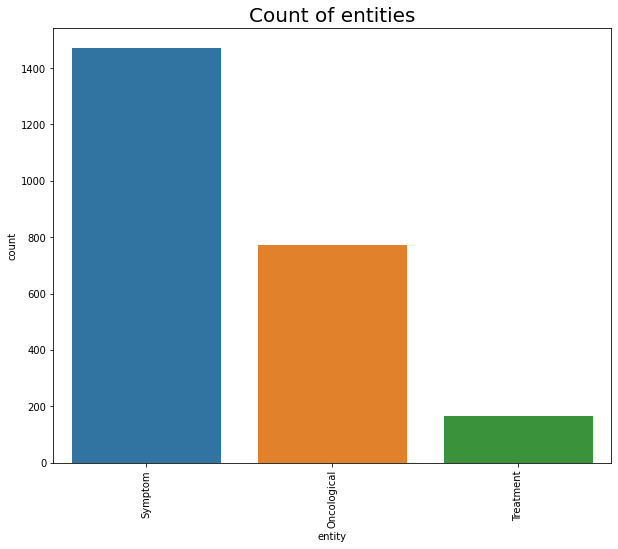

<matplotlib.axes._subplots.AxesSubplot at 0x7fde015c8a30>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.title("Count of entities", size=20)
sns.countplot(icd10_hcc_df.entity, order=icd10_hcc_df["entity"].value_counts().index)


## 1.1. Get general information for staff management, reporting, & planning.

Let's map diagnosis codes to parent categories to see which indications have most cases. 

We have defined a function and applied it to `icd10_code`.

In [0]:
icd10_oncology_mapping = {"C81-C96": "Malignant neoplasms of lymphoid, hematopoietic and related tissue",
                          "C76-C80": "Malignant neoplasms of ill-defined, other secondary and unspecified sites",
                          "D00-D09": "In situ neoplasms",
                          "C51-C58": "Malignant neoplasms of female genital organs",
                          "C43-C44": "Melanoma and other malignant neoplasms of skin",
                          "C15-C26": "Malignant neoplasms of digestive organs",
                          "C73-C75": "Malignant neoplasms of thyroid and other endocrine glands",
                          "D60-D64": "Aplastic and other anemias and other bone marrow failure syndromes",
                          "E70-E88": "Metabolic disorders",
                          "G89-G99": "Other disorders of the nervous system",
                          "R50-R69": "General symptoms and signs",
                          "R10-R19": "Symptoms and signs involving the digestive system and abdomen",
                          "Z00-Z13": "Persons encountering health services for examinations"}


def map_to_parent(x):
    charcode = x[0].lower()
    numcodes = int(x[1])
    
    for k, v in icd10_oncology_mapping.items():
        
        lower, upper = k.split('-')
        
        if charcode >= lower[0].lower() and numcodes >= int(lower[1]):
            
            if charcode < upper[0].lower():
                return v
            elif charcode == upper[0].lower() and numcodes <= int(upper[1]):
                return v

In [0]:
icd10_hcc_df["onc_code_desc"] = icd10_hcc_df["icd10_code"].apply(map_to_parent).fillna("-")
icd10_hcc_df.onc_code_desc.value_counts()

Out[226]: - 1439
General symptoms and signs 280
Malignant neoplasms of lymphoid, hematopoietic and related tissue 210
Symptoms and signs involving the digestive system and abdomen 173
Melanoma and other malignant neoplasms of skin 96
Malignant neoplasms of ill-defined, other secondary and unspecified sites 72
Malignant neoplasms of female genital organs 72
Malignant neoplasms of digestive organs 24
In situ neoplasms 15
Metabolic disorders 11
Persons encountering health services for examinations 9
Aplastic and other anemias and other bone marrow failure syndromes 4
Other disorders of the nervous system 2
Name: onc_code_desc, dtype: int64

**Lets plot a countplot to see the number of each parent categories.**

Out[227]:

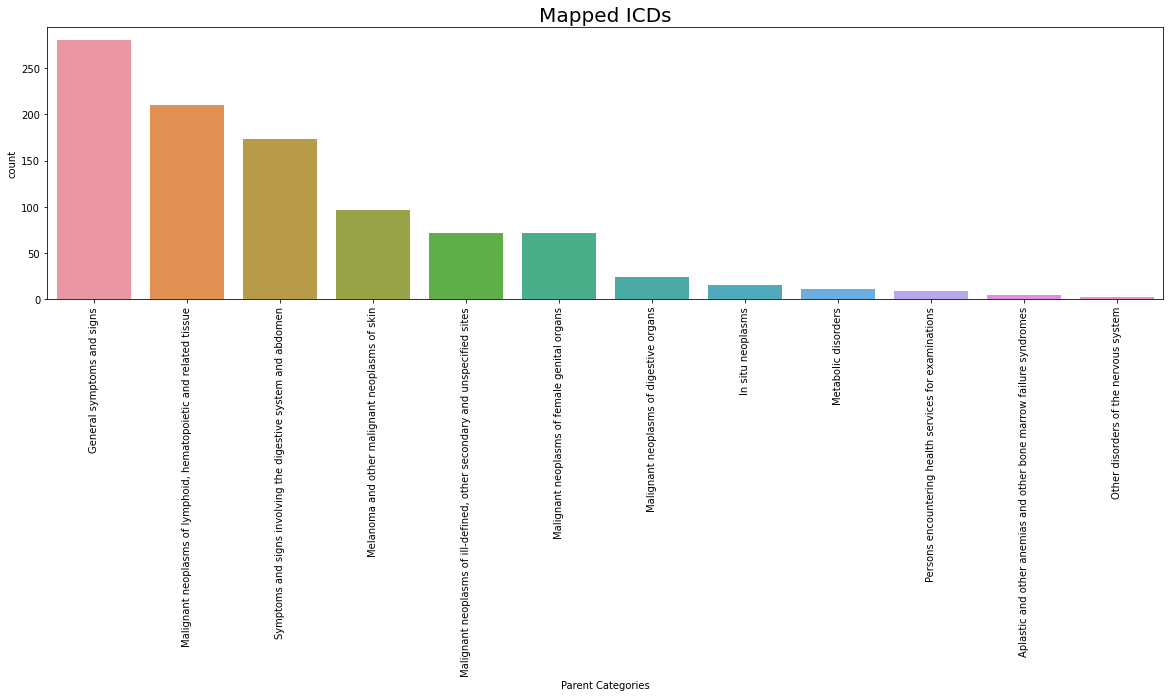

Text(0.5, 0, 'Parent Categories')

In [0]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
temp_df = icd10_hcc_df[icd10_hcc_df.onc_code_desc != "-"]

sns.countplot(temp_df.onc_code_desc, order=temp_df.onc_code_desc.value_counts().index)
plt.title("Mapped ICDs", size=20)
plt.xlabel("Parent Categories")

## 1.2. Preparing reimbursement-ready data with billable codes

Here, we will check how many of the ICD codes are billable.

In [0]:
print(icd10_hcc_df['icd_code_billable'].value_counts())

1 1735
0 672
Name: icd_code_billable, dtype: int64

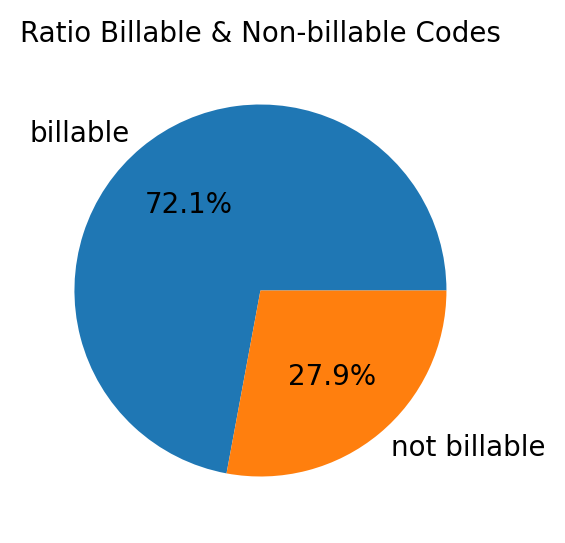

In [0]:
plt.figure(figsize=(3,4), dpi=200)
plt.pie(icd10_hcc_df['icd_code_billable'].value_counts(), 
        labels = ["billable", "not billable"], 
        autopct = "%1.1f%%"
       )
plt.title("Ratio Billable & Non-billable Codes", size=10)
plt.show()

**As we can see, some of the best matching codes are not billable. For such indications we can find codes that are relevant as well as billable.**

In [0]:
best_paid_icd_matches = []
indication_with_no_billable_icd = []

for i_, row in icd10_hcc_df.iterrows():
    if '1' not in row['billable']:
        indication_with_no_billable_icd.append([row['final_chunk'], 
                                      row['resolutions'][0], 
                                      row['all_codes'][0],
                                      row['billable'][0],
                                      row['hcc_score'][0],
                                      row['onc_code_desc'], 
                                      "-" ])
    else:
        n_zero_ind = row['billable'].index('1')
        best_paid_icd_matches.append([row['final_chunk'], 
                                      row['resolutions'][n_zero_ind], 
                                      row['all_codes'][n_zero_ind],
                                      row['billable'][n_zero_ind],
                                      row['hcc_score'][n_zero_ind],
                                      row['onc_code_desc'],
                                      n_zero_ind])

best_icd_mapped = pd.DataFrame(best_paid_icd_matches, columns=['ner_chunk', 'code', 'code_desc', 'billable', 
                                             'corresponding_hcc_score', 'onc_code_desc', 'nearest_billable_code_pos'])
best_icd_mapped['corresponding_hcc_score'] = pd.to_numeric(best_icd_mapped['corresponding_hcc_score'], errors='coerce')

best_icd_mapped.head()

Out[230]:

,ner_chunk,code,code_desc,billable,corresponding_hcc_score,onc_code_desc,nearest_billable_code_pos
0,Mesothelioma,malignant mesothelioma,C459,1,9.0,Melanoma and other malignant neoplasms of skin,1
1,tenderness,tenderness,R529,1,0.0,General symptoms and signs,0
2,breakdown,deficit,R4689,1,0.0,-,3
3,lesions,multiple lesions (finding),J984,1,0.0,-,0
4,ulcers,ulcer,L989,1,0.0,-,0


**All chunks have been mapped to payable ICD codes**

In [0]:
print(best_icd_mapped.billable.value_counts())

1 2407
Name: billable, dtype: int64

In [0]:
print("Number of non-billable ICD Codes: ",len(indication_with_no_billable_icd))

Number of non-billable ICD Codes: 0

**Lets take a look at the position of nearest codes that was taken for making billable**

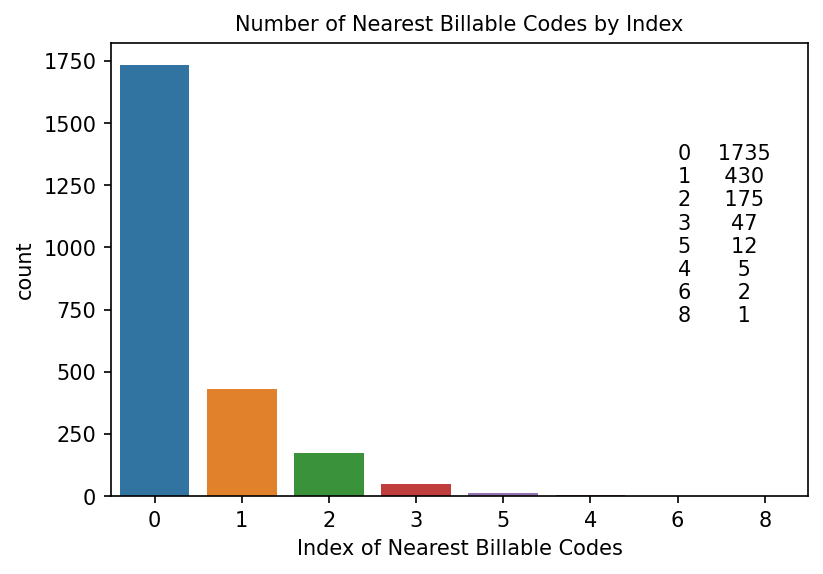

In [0]:
plt.figure(figsize=(6,4), dpi=150)
sns.countplot(best_icd_mapped['nearest_billable_code_pos'], order = best_icd_mapped.nearest_billable_code_pos.value_counts().index)
plt.title("Number of Nearest Billable Codes by Index", size=10)
plt.xlabel("Index of Nearest Billable Codes", size=10)
plt.text(6, 700, best_icd_mapped.nearest_billable_code_pos.value_counts().to_string())

plt.show()

## 1.3. See which indications have highest average risk factor

In our pipeline we used `sbiobertresolve_icd10cm_augmented_billable_hcc` as Sentence resolver. So the model return HCC codes. We can calculate the risk per indication by getting the averages.

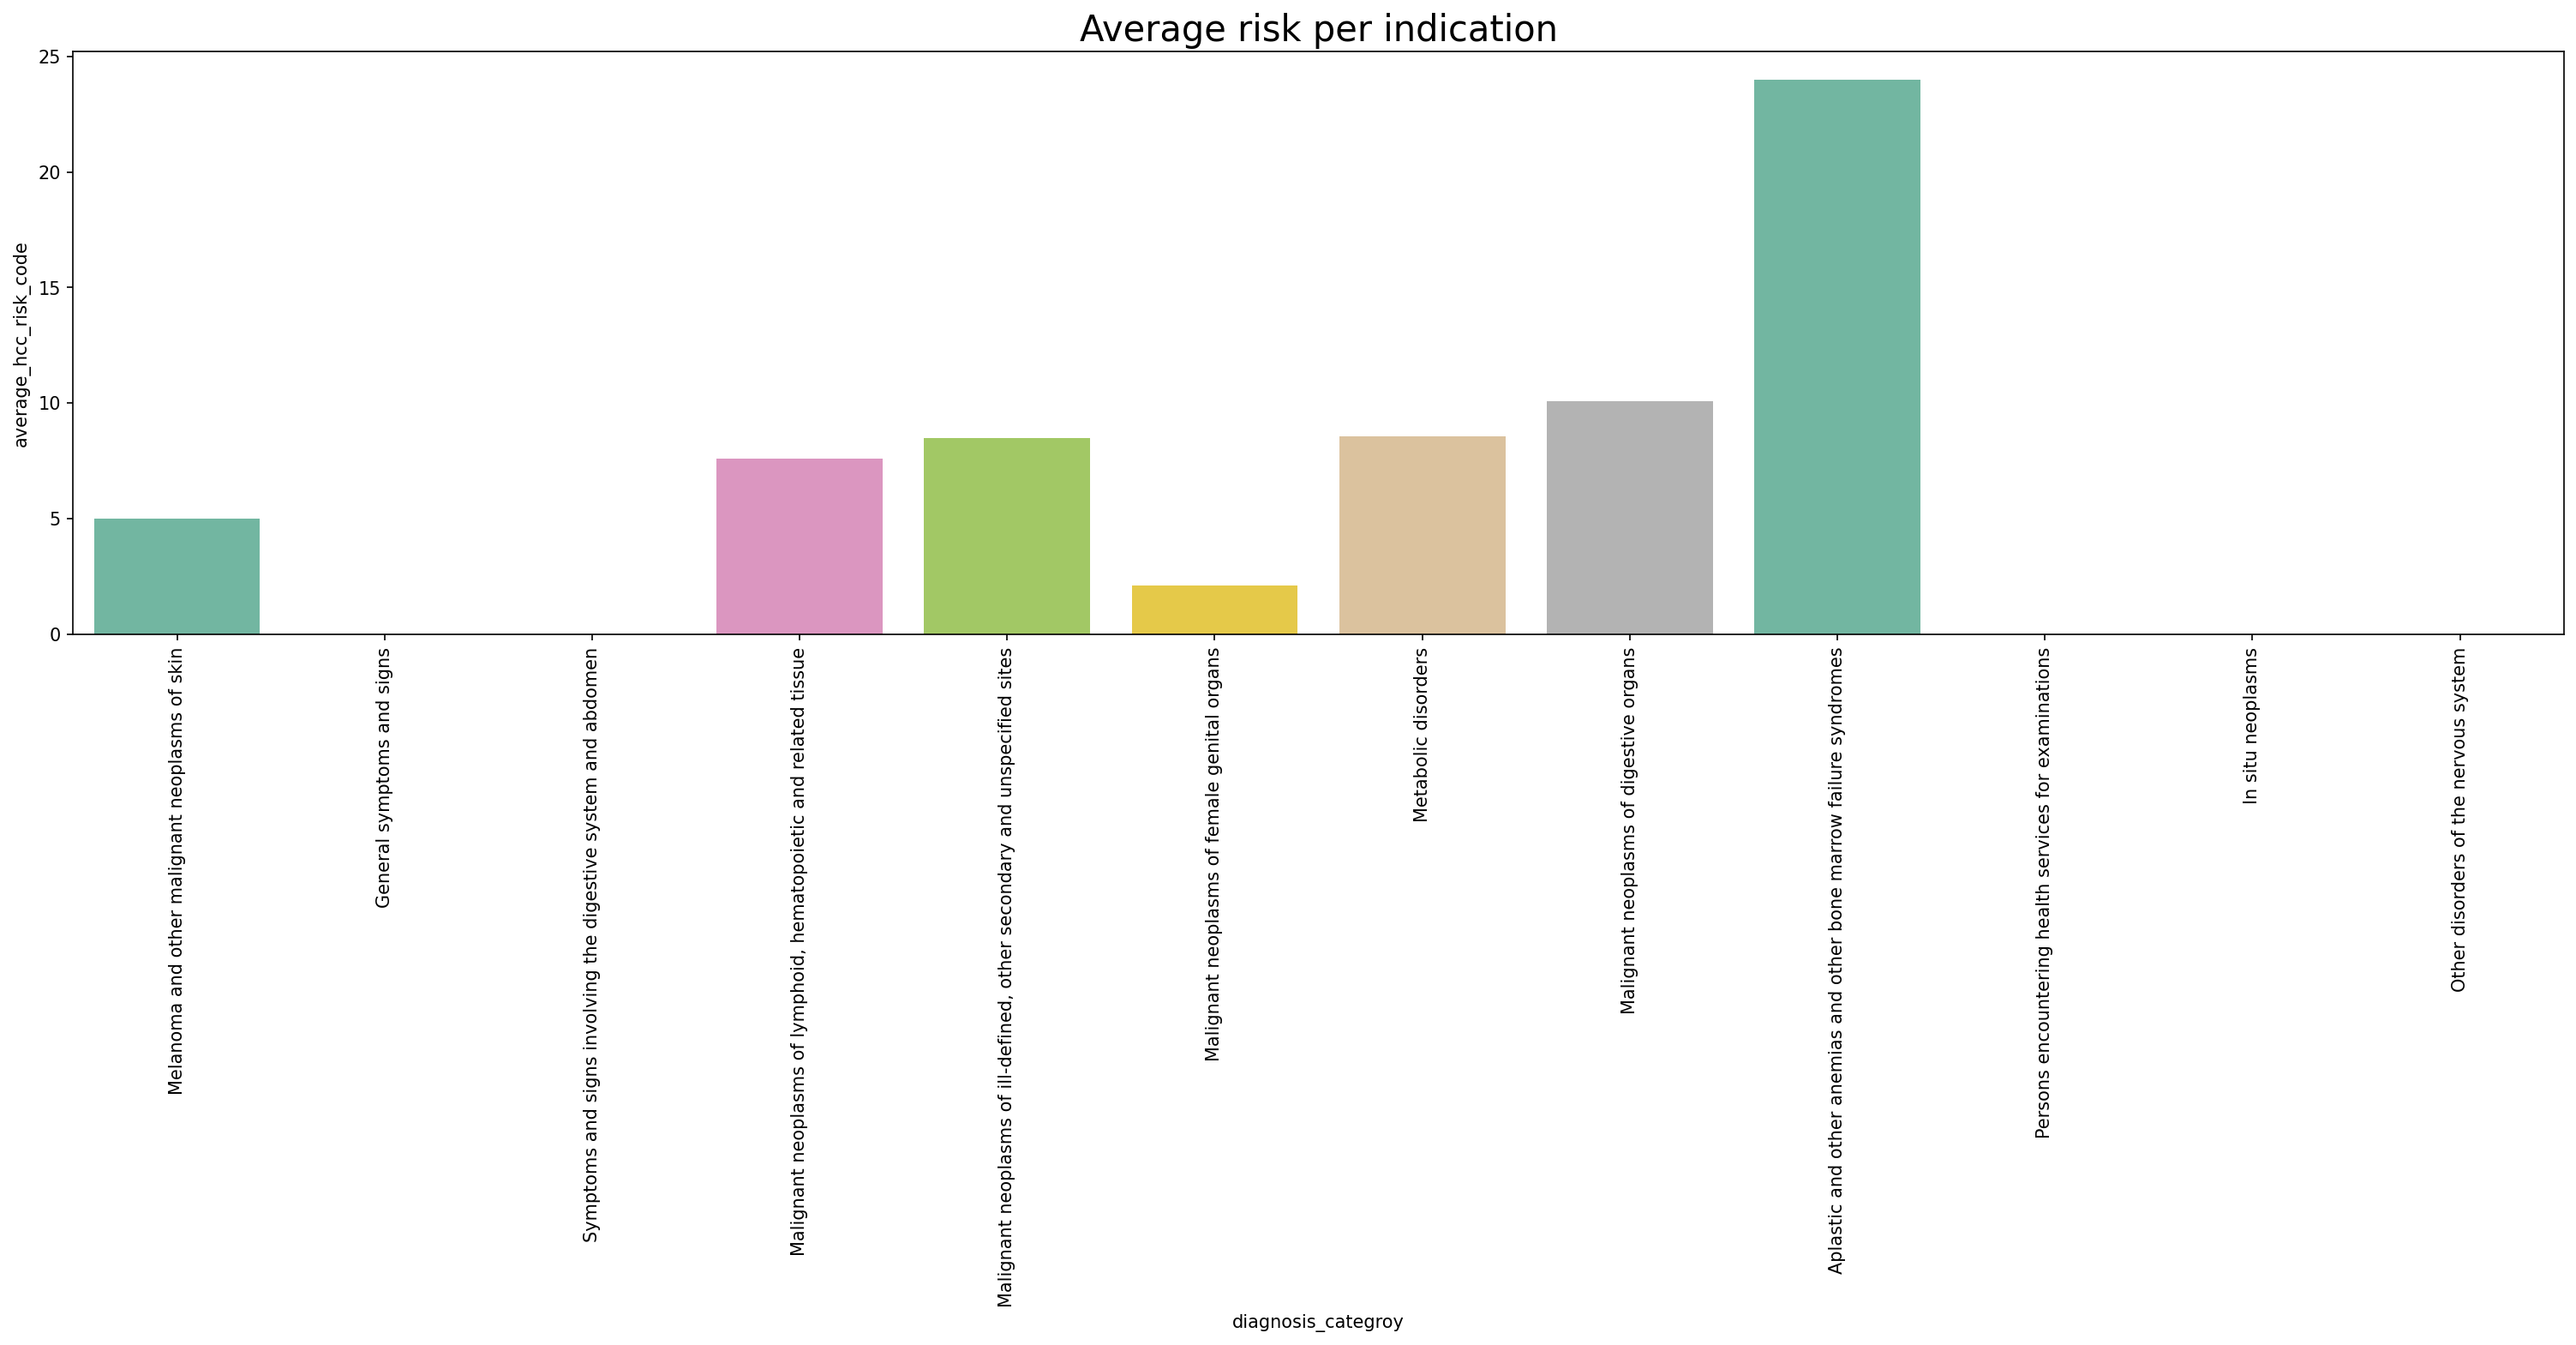

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(25,6), dpi=150)

sns.barplot(x='onc_code_desc', y='corresponding_hcc_score',
            data = best_icd_mapped[best_icd_mapped.onc_code_desc != "-"], ci = None,
            palette="Set2")

plt.title('Average risk per indication', size=20)
plt.xlabel('diagnosis_categroy')
plt.ylabel('average_hcc_risk_code')
plt.xticks(rotation=90)
plt.show()


**As we can see, some categories, even with fewer cases, have higher risk factor.**

## 1.4. Analyze Oncological Entities
We can find the most frequent oncological entities.

In [0]:
onc_df = icd10_hcc_df[icd10_hcc_df.entity=="Oncological"].iloc[:, [0,1,2,3,10,11]]
onc_df.head()

Out[235]:

,path,final_chunk,entity,icd10_code,icd_codes_names,icd_code_billable
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Mesothelioma,Oncological,C45,mesothelioma,0
9,dbfs:/oncology_notes_mt/mt_oncology_0.txt,epithelioid malignant mesothelioma,Oncological,C459,malignant mesothelioma,1
14,dbfs:/oncology_notes_mt/mt_oncology_0.txt,mesothelioma,Oncological,C45,mesothelioma,0
15,dbfs:/oncology_notes_mt/mt_oncology_0.txt,pleural,Oncological,R0989,pleural rub,1
18,dbfs:/oncology_notes_mt/mt_oncology_0.txt,mesothelioma,Oncological,C45,mesothelioma,0


In [0]:
print(onc_df.icd_codes_names.value_counts().head(20))

tumor configuration 48
breast cancer 31
cancer 27
squamous cell carcinoma 23
mesothelioma 23
breast present 19
metastases 19
nodular basal cell carcinoma 18
lymphoma 17
carcinoma 17
brain tumor 13
lung cancer 12
descending colon cancer 12
parathyroid adenoma 12
biopsy finding 10
eccrine ductal carcinoma 10
mantle cell lymphoma 10
lobular carcinoma in situ of left breast 9
glioma 9
neoplasm 8
Name: icd_codes_names, dtype: int64

Out[237]:

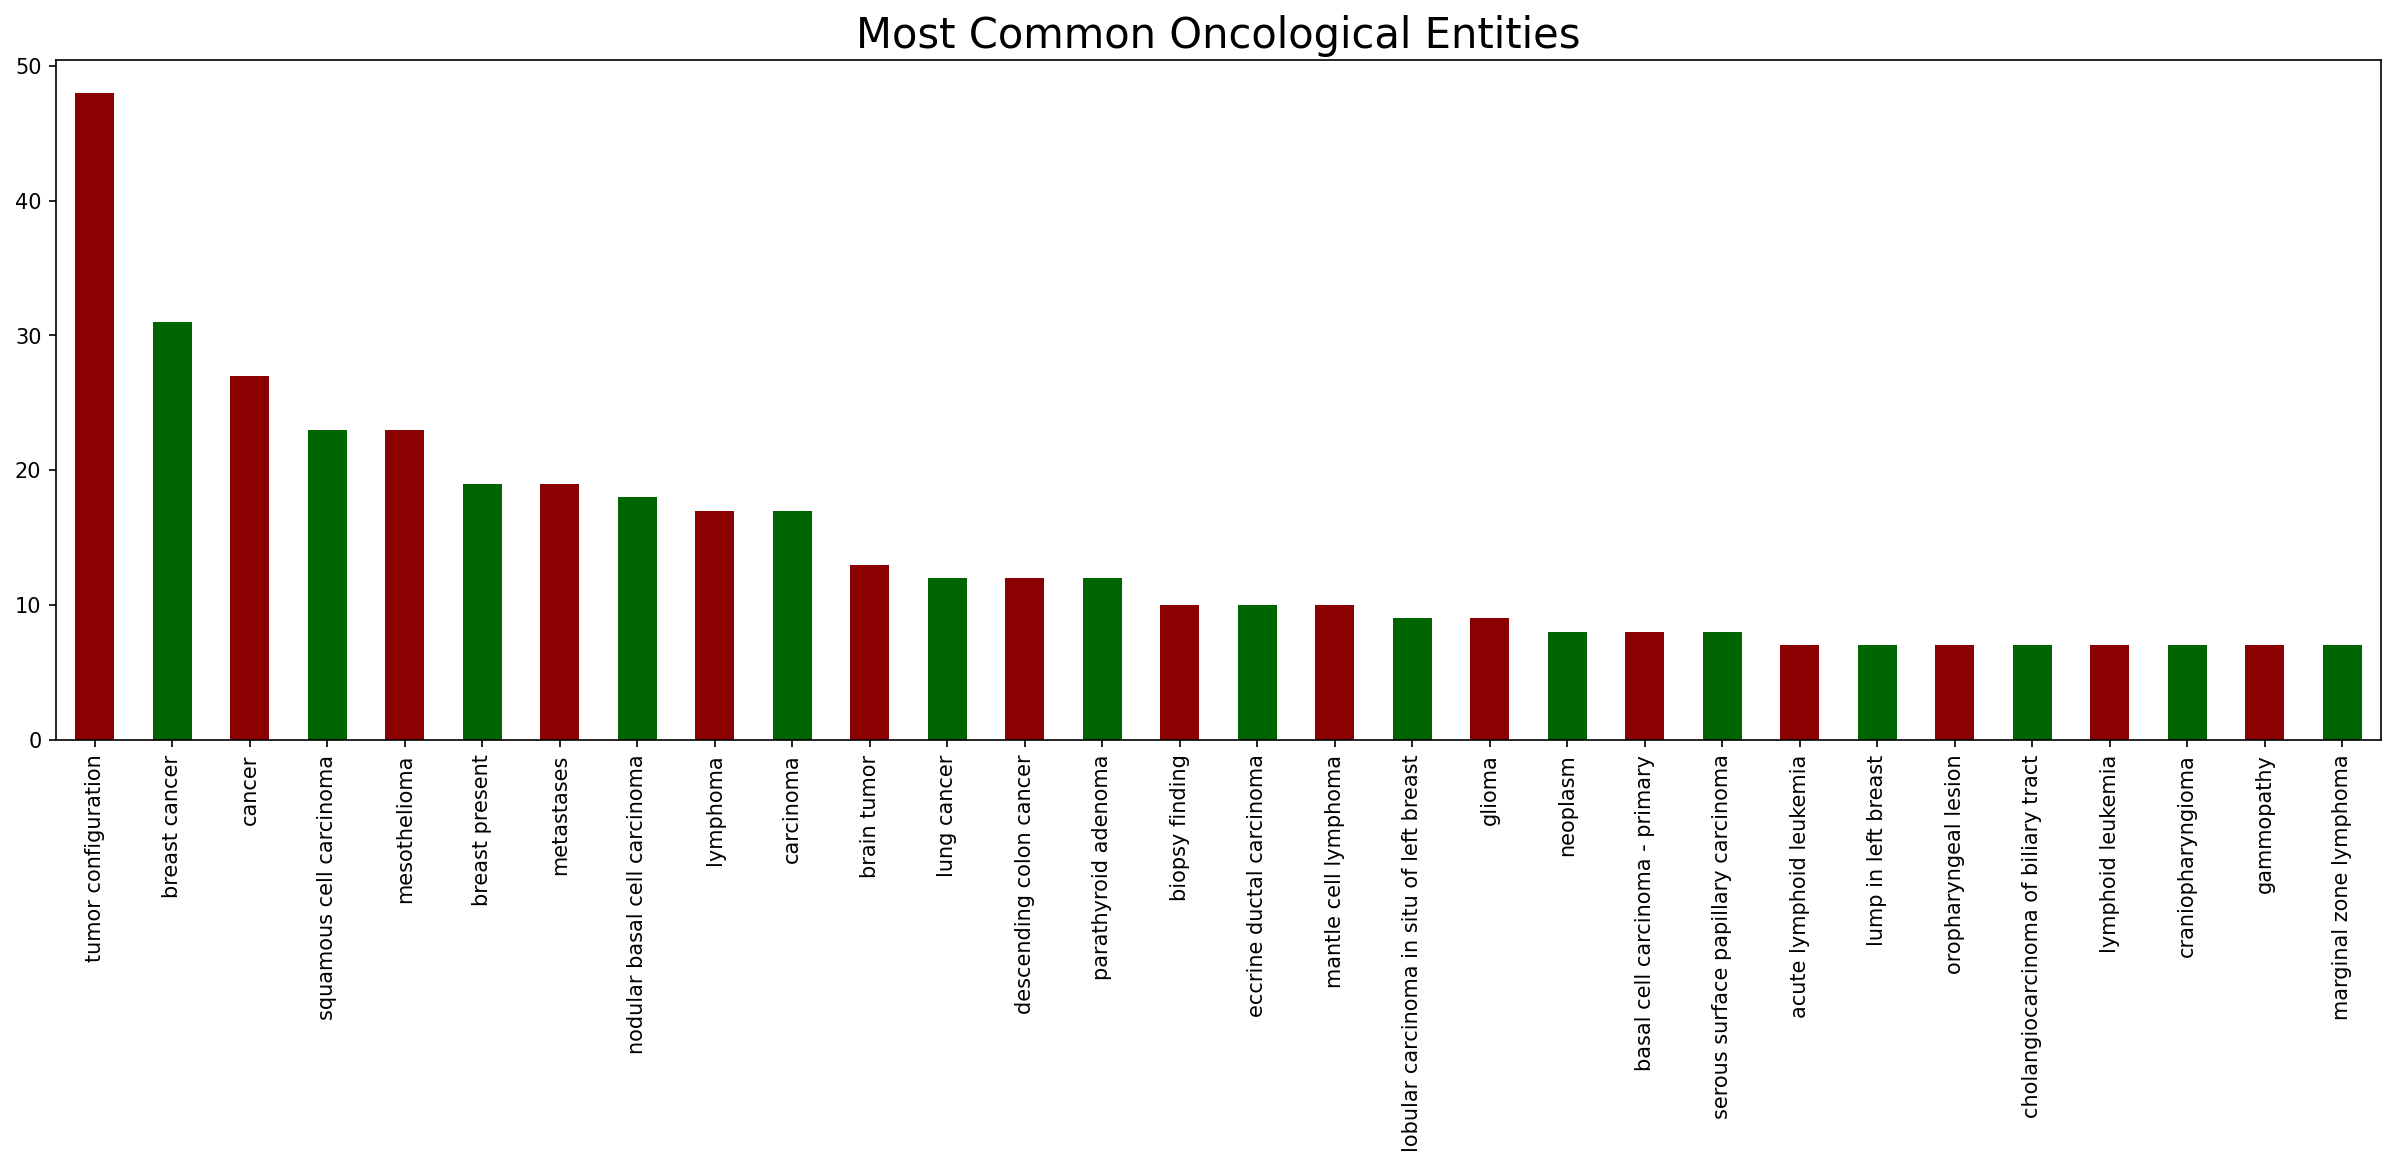

<matplotlib.axes._subplots.AxesSubplot at 0x7fde00812b20>

In [0]:
plt.figure(figsize=(20,6), dpi=150)
plt.xticks(rotation=90)
plt.title('Most Common Oncological Entities', size=20)
onc_df.icd_codes_names.value_counts().head(30).plot(kind='bar', color=['darkred', 'darkgreen'])

## 1.5. Report Counts by ICD10CM Code Names
Each bar shows count of reports contain the cancer entities.

In [0]:
most_common_icd_codes = onc_df.icd_codes_names.value_counts().index[:20]
print(most_common_icd_codes)

Index(['tumor configuration', 'breast cancer', 'cancer',
 'squamous cell carcinoma', 'mesothelioma', 'breast present',
 'metastases', 'nodular basal cell carcinoma', 'lymphoma', 'carcinoma',
 'brain tumor', 'lung cancer', 'descending colon cancer',
 'parathyroid adenoma', 'biopsy finding', 'eccrine ductal carcinoma',
 'mantle cell lymphoma', 'lobular carcinoma in situ of left breast',
 'glioma', 'neoplasm'],
 dtype='object')

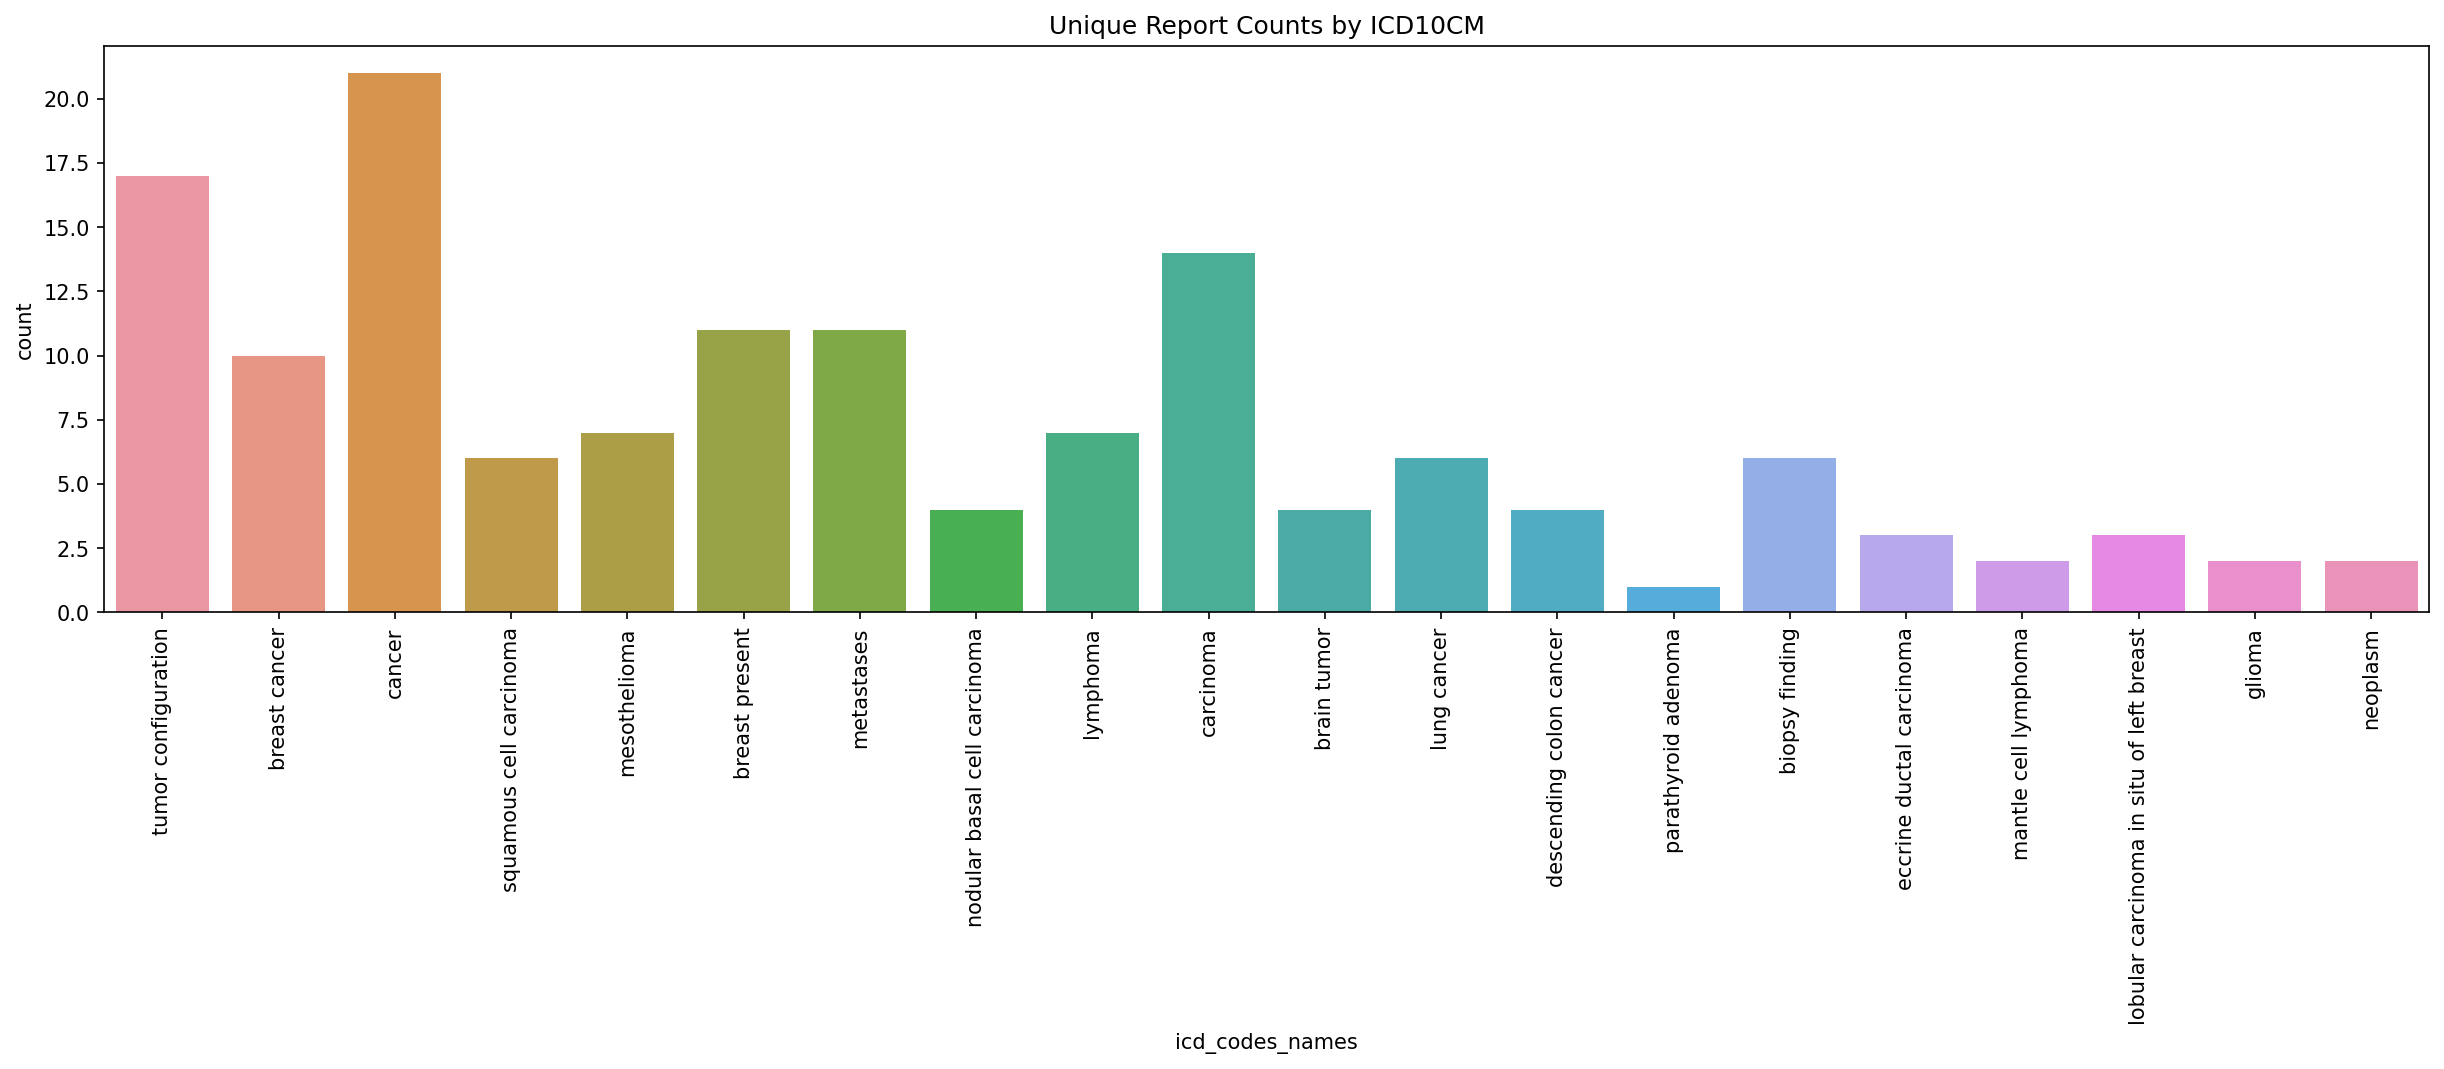

In [0]:
unique_icd_code_names = onc_df[onc_df.icd_codes_names.isin(most_common_icd_codes)].groupby(["path","icd_codes_names"]).count().reset_index()[["path","icd_codes_names"]]	

plt.figure(figsize=(20,5), dpi=150)
plt.xticks(rotation=90)
plt.title('Unique Report Counts by ICD10CM')

sns.countplot(unique_icd_code_names.icd_codes_names, order=most_common_icd_codes)
plt.show()

## 1.6. Most common symptoms
 We can find the most common symptoms counting the unique symptoms in documents.

In [0]:
symptom_df = icd10_hcc_df[icd10_hcc_df.entity.isin(["Symptom"])].iloc[:, [0,1,2,3,10,11]]
symptom_df.rename(columns={"icd_codes_names":"symptom"}, inplace=True)
symptom_df.head()

Out[240]:

,path,final_chunk,entity,icd10_code,symptom,icd_code_billable
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,tenderness,Symptom,R529,tenderness,1
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,breakdown,Symptom,R090,collapse,0
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,lesions,Symptom,J984,multiple lesions (finding),1
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,ulcers,Symptom,L989,ulcer,1
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,focal deficits,Symptom,R298,focal motor weakness (finding),0


In [0]:
unique_symptoms = symptom_df.groupby(["path","symptom"]).count().reset_index()[["path","symptom"]]	
most_common_symptoms = unique_symptoms.symptom.value_counts().index[:30]
print(most_common_symptoms)

Index(['edema', 'murmur', 'mass', 'pain', 'hepatosplenomegaly', 'distress',
 'night sweats', 'anismus', 'nausea', 'shortness of breath', 'chill',
 'vomiting', 'chest pain', 'bleeding', 'headache', 'abdominal mass',
 'lymphadenopathy', 'does not move hand', 'endocrinopathy', 'wound',
 'fatigue', 'non-arousal', 'cough', 'retching',
 'lesioned component (finding)', 'summation gallop', 'diarrhea',
 'abdominal pain', 'petechiae', 'finger clubbing'],
 dtype='object')

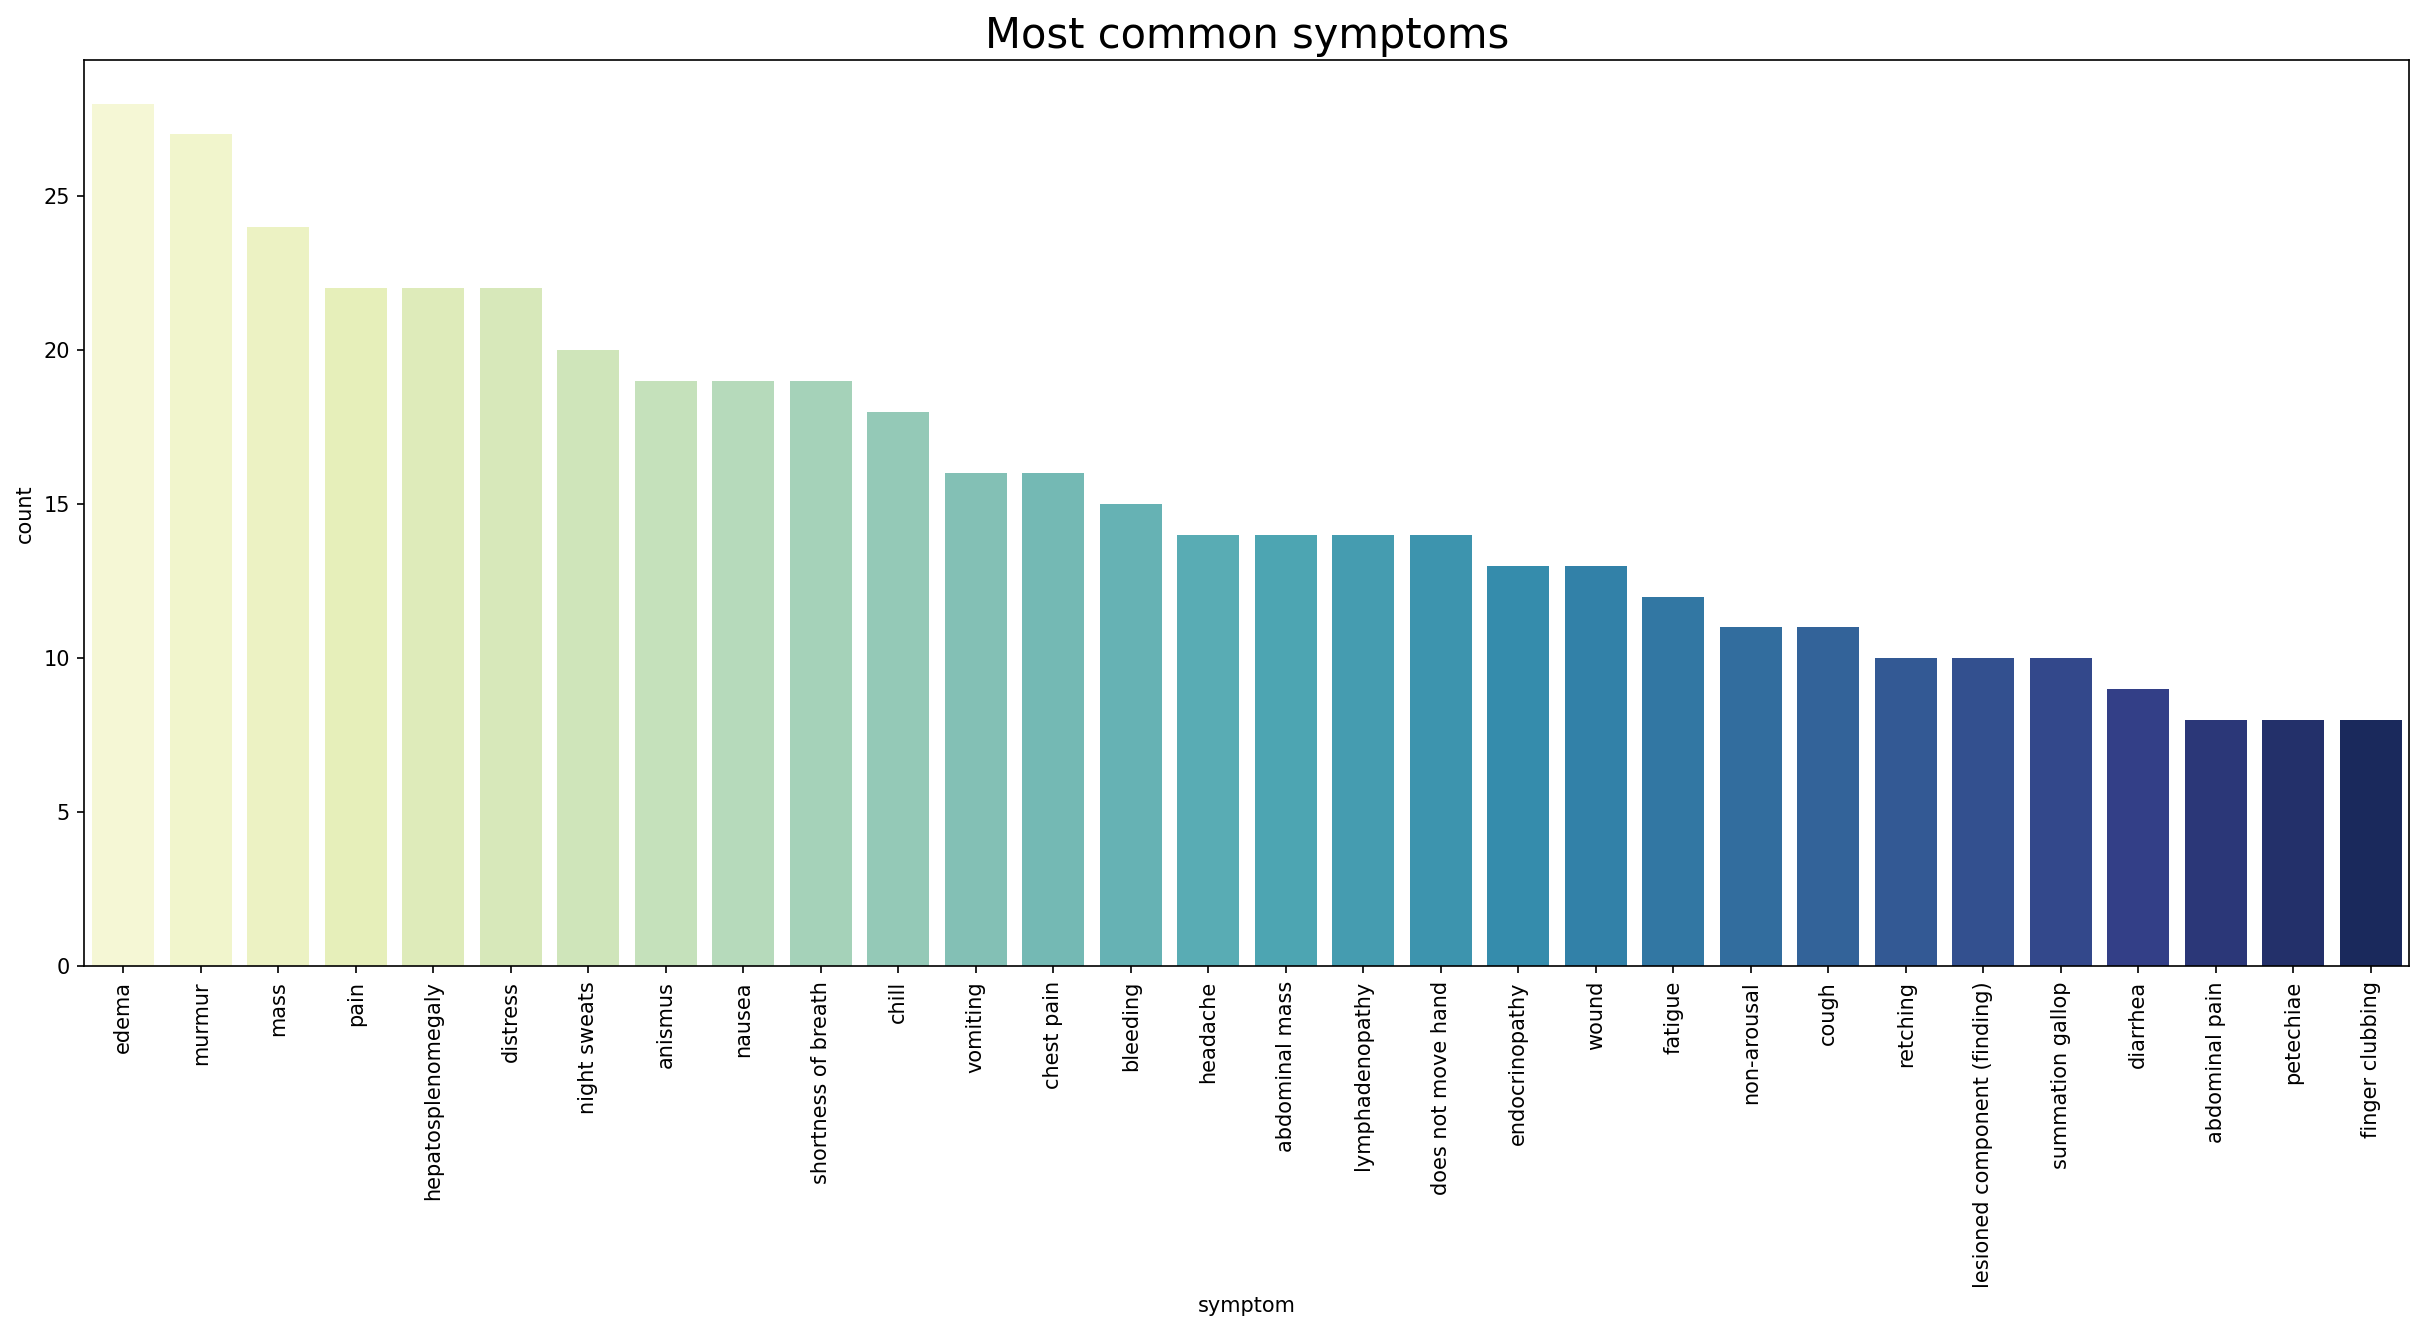

In [0]:
plt.figure(figsize=(20,8), dpi=150)
plt.xticks(rotation=90)
plt.title('Most common symptoms', size=20)
sns.countplot(unique_symptoms.symptom, order=most_common_symptoms, palette="YlGnBu")
plt.show()

## 1.7. Extract most frequent oncological diseases and symptoms based on documents

Here, we will count the number documents for each symptom-disease pair.

In [0]:
#Getting the list of the most common code names.
top_20_code_names = unique_icd_code_names.groupby("icd_codes_names").count().sort_values(by="path", ascending=False).iloc[:20].index

#Getting the list of common symptoms.
top_20_symptom = unique_symptoms.groupby("symptom").count().sort_values(by="path", ascending=False).iloc[:20].index

We are merging `unique_icd_code_names` and `unique_symptoms` dataframes and then pivotting it before plotting an heatmap.

In [0]:
merged_df = pd.merge(unique_icd_code_names[unique_icd_code_names.icd_codes_names.isin(top_20_code_names)],
                     unique_symptoms[unique_symptoms.symptom.isin(top_20_symptom)],
                     on = "path").groupby(["icd_codes_names", "symptom"]).count().reset_index()

sympytom_cancer = merged_df.pivot_table(index="symptom", columns=["icd_codes_names"], values="path", fill_value=0)

sympytom_cancer

Out[244]:

icd_codes_names,biopsy finding,brain tumor,breast cancer,breast present,cancer,carcinoma,descending colon cancer,eccrine ductal carcinoma,glioma,lobular carcinoma in situ of left breast,lung cancer,lymphoma,mantle cell lymphoma,mesothelioma,metastases,neoplasm,nodular basal cell carcinoma,squamous cell carcinoma,tumor configuration
symptom,,,,,,,,,,,,,,,,,,,
abdominal mass,1,0,4,2,7,5,1,2,0,1,2,0,1,2,4,0,1,0,1
anismus,1,1,6,4,7,2,0,2,0,0,4,3,0,2,6,0,0,1,1
bleeding,0,0,2,2,4,5,0,1,0,1,1,0,0,2,3,0,1,1,3
chest pain,0,1,4,2,8,5,1,2,1,1,5,1,0,2,6,0,1,2,1
chill,1,0,4,4,5,4,0,2,0,1,3,3,0,1,5,0,0,1,1
distress,0,1,3,1,8,4,2,0,0,0,5,2,1,1,7,0,0,1,1
does not move hand,0,0,3,1,5,2,2,1,0,0,2,1,1,3,3,0,0,1,0
edema,1,1,4,4,7,4,1,2,1,1,3,3,0,1,4,1,1,1,3
endocrinopathy,0,1,2,2,4,4,1,2,1,1,1,2,1,2,3,1,0,2,1


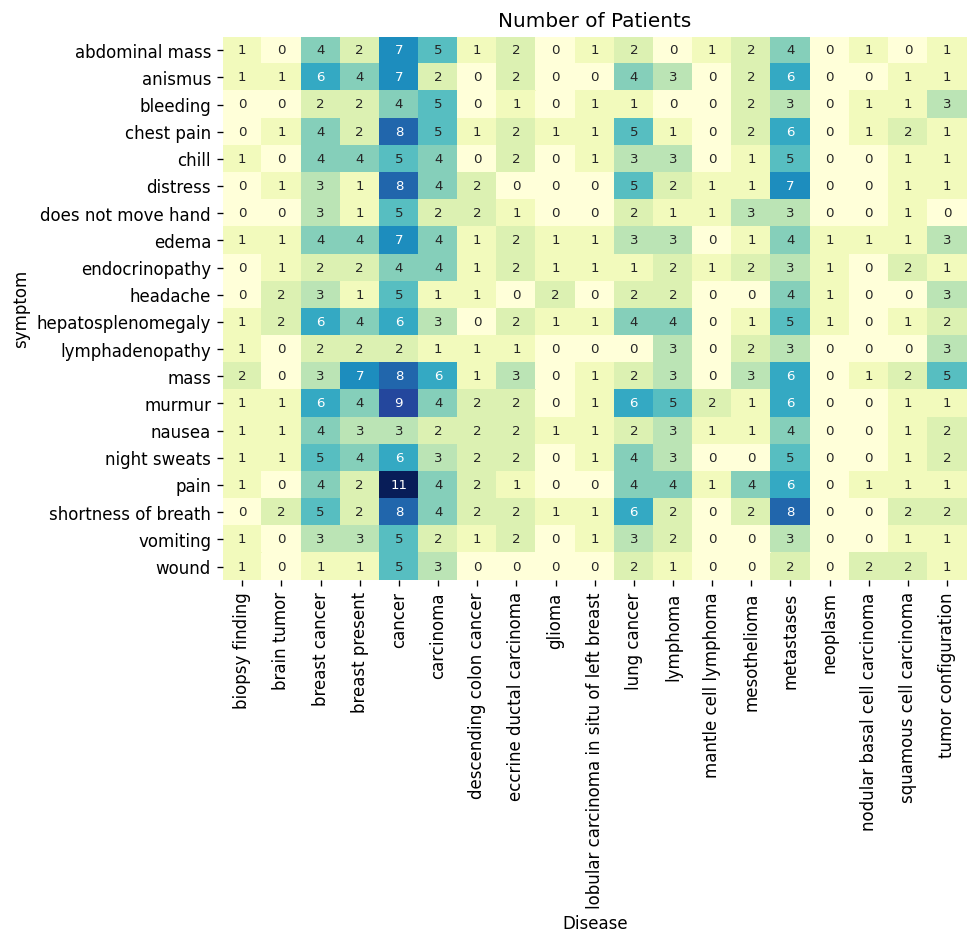

In [0]:
plt.figure(figsize=(8,6), dpi=120)
sns.heatmap(sympytom_cancer, annot=True, cbar=False, annot_kws={"size": 8}, cmap = "YlGnBu")
plt.title('Number of Patients')
plt.xlabel('Disease')
plt.show()

**We can see the most common diseases and symptoms on different patients. For example, 11 cancer patients has pain symptom.**

# 2. Get Drug codes from the notes

We will create a new pipeline to get drug codes. As NER model, we are using `ner_posology_large` and setting NerConverter's WhiteList `['DRUG']` in order to get only drug entities.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

## to get drugs
drugs_ner_ing = MedicalNerModel.pretrained("ner_posology_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")

drugs_ner_converter_ing = NerConverter() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["DRUG"])
  
drugs_c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

sbert_embedder_ing = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

rxnorm_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_rxnorm","en", "clinical/models")\
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

pipeline_rxnorm_ingredient = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_ing,
        drugs_ner_converter_ing, 
        drugs_c2doc, 
        sbert_embedder_ing,
        rxnorm_resolver])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_model = pipeline_rxnorm_ingredient.fit(data_ner)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_large download started this may take some time.
Approximate size to download 13.8 MB
[ | ][ / ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
demo_sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

In [0]:
rxnorm_code_res = rxnorm_model.transform(df) 

We are getting selecting the columns which we need and converting to Pandas DataFrame. The values in `all_codes` and `resolitions` columns are seperated by ":::" and we are converting these columns to lists.

In [0]:
rxnorm_res = rxnorm_code_res.select("path", F.explode(F.arrays_zip( 'ner_chunk.result', 'rxnorm_code.result', 'rxnorm_code.metadata')).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("drug_chunk"),
                                            F.expr("cols['1']").alias("rxnorm_code"),
                                            F.expr("cols['2']['confidence']").alias("confidence"),
                                            F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                            F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()


codes = []
resolutions = []

for code, resolution in zip(rxnorm_res['all_codes'], rxnorm_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_res['all_codes'] = codes  
rxnorm_res['resolutions'] = resolutions
rxnorm_res['drugs'] = rxnorm_res['resolutions'].apply(lambda x : x[0])

In [0]:
rxnorm_res.head(10)

Out[134]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Amiodarone,703,0.6925,"[703, 544501, 1663223, 484718, 1151983, 1151982, 577358, 1663270, 203114, 1151981, 377132, 54450...","[amiodarone, aniodarone, amiodarone injection, aminodarone, amiodarone pill, amiodarone oral pro...",amiodarone
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Lovenox,225036,0.0800,"[225036, 542606, 224937, 540404, 1999683, 218173, 317261, 215354, 833136, 686430, 1363715, 21031...","[lovenox, lutera, sanorex, lunesta, lutathera, magnalox, permirolast, anutone-hc, savella, liald...",lovenox
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chemotherapy,215982,0.2013,"[215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636...","[chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carbo...",chemdec
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cisplatin,2555,0.9909,"[2555, 1736853, 40048, 1152129, 1736856, 376433, 404931, 152200, 219265, 3639, 202852, 363065, 1...","[cisplatin, cisplatin injection, carboplatin, cisplatin injectable product, cisplatin injection ...",cisplatin
6,dbfs:/oncology_notes_mt/mt_oncology_0.txt,piggyback,33926,0.0801,"[33926, 2174096, 385405, 225201, 7951, 824155, 2359335, 219206, 7930, 202899, 33432, 152218, 128...","[poldine, polivy, ponoxylan, privine, pavulon, phenasep, pemazyre, phenerbel-s, pargyline, papul...",poldine
7,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Alimta,215178,0.0647,"[215178, 479, 323879, 615205, 2049374, 215085, 152800, 1727480, 1806646, 151318, 215075, 769, 15...","[altafed, alfenta, alimta, amitiza, alfaxan, aldara, amilamont, alecensa, ameluz, aldomet, albal...",altafed
8,dbfs:/oncology_notes_mt/mt_oncology_0.txt,piggyback,33926,0.0801,"[33926, 2174096, 385405, 225201, 7951, 824155, 2359335, 219206, 7930, 202899, 33432, 152218, 128...","[poldine, polivy, ponoxylan, privine, pavulon, phenasep, pemazyre, phenerbel-s, pargyline, papul...",poldine
9,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chemotherapy,215982,0.2013,"[215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636...","[chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carbo...",chemdec


**Visualize Drug Entities** 

Now we will visualize a sample text with `NerVisualizer`.

In [0]:
sample_text = df.limit(1).select("text").collect()[0]

print(sample_text)

Row(text='Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.\nPAST MEDICAL HISTORY\n1. Pericardectomy.\n2. Pericarditis.\n2. Atrial fibrillation.\n4. RNCA with intracranial thrombolytic treatment.\n5 PTA of MCA.\n6. Mesenteric venous thrombosis.\n7. Pericardial window.\n8. Cholecystectomy.\n9. Left thoracentesis.\nFAMILY HISTORY:\nNo family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.\nSOCIAL HISTORY:\nShe is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.\nMEDICATIONS\n1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.\n2. Amiodarone 100 mg p.o. daily.\nREVIEW OF SYSTEMS:\nComplete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.\nPHYSICAL EXAMINATION\nVITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.\nGENERAL: Positive nonproductive cough and pain with coughing.\nHEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.\nNECK: Supple. No lymphadenopathy. No masses.\nRESPIRATORY: Pleural friction rub is noted.\nGI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.\nEXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.\nSKIN: No breakdown or lesions. No ulcers.\nNEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.\nLABORATORY DATA:\nLabs are pending.\nHOSPITAL COURSE:\nThe patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid bio

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our `rxnorm_model`.

In [0]:
light_model =  LightPipeline(rxnorm_model)

ann_text = light_model.fullAnnotate(sample_text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'sentence_embeddings', 'token', 'rxnorm_code', 'ner_drug', 'embeddings', 'ner_chunk_doc', 'sentence'])

In [0]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin DRUG 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone DRUG 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox DRUG 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which reve

## 2.1. Analyze drug usage patterns for inventory management and reporting

We are checking how many times any drug are encountered in the documents.

In [0]:
rxnorm_res.head()

Out[135]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Amiodarone,703,0.6925,"[703, 544501, 1663223, 484718, 1151983, 1151982, 577358, 1663270, 203114, 1151981, 377132, 54450...","[amiodarone, aniodarone, amiodarone injection, aminodarone, amiodarone pill, amiodarone oral pro...",amiodarone
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Lovenox,225036,0.0800,"[225036, 542606, 224937, 540404, 1999683, 218173, 317261, 215354, 833136, 686430, 1363715, 21031...","[lovenox, lutera, sanorex, lunesta, lutathera, magnalox, permirolast, anutone-hc, savella, liald...",lovenox
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chemotherapy,215982,0.2013,"[215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636...","[chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carbo...",chemdec


In [0]:
print(rxnorm_res.drugs.value_counts())

chemdec 79
hush anesthetic 18
heparin 16
coumadin 16
prednisone 15
 ..
vitamin a 1
luvox 1
prevacid 1
nerve growth factor 1
avinza 1
Name: drugs, Length: 307, dtype: int64

## 2.2. Analyze most frequent used drugs for different cancer patients

For each drug, we are counting the unique documents encountered.

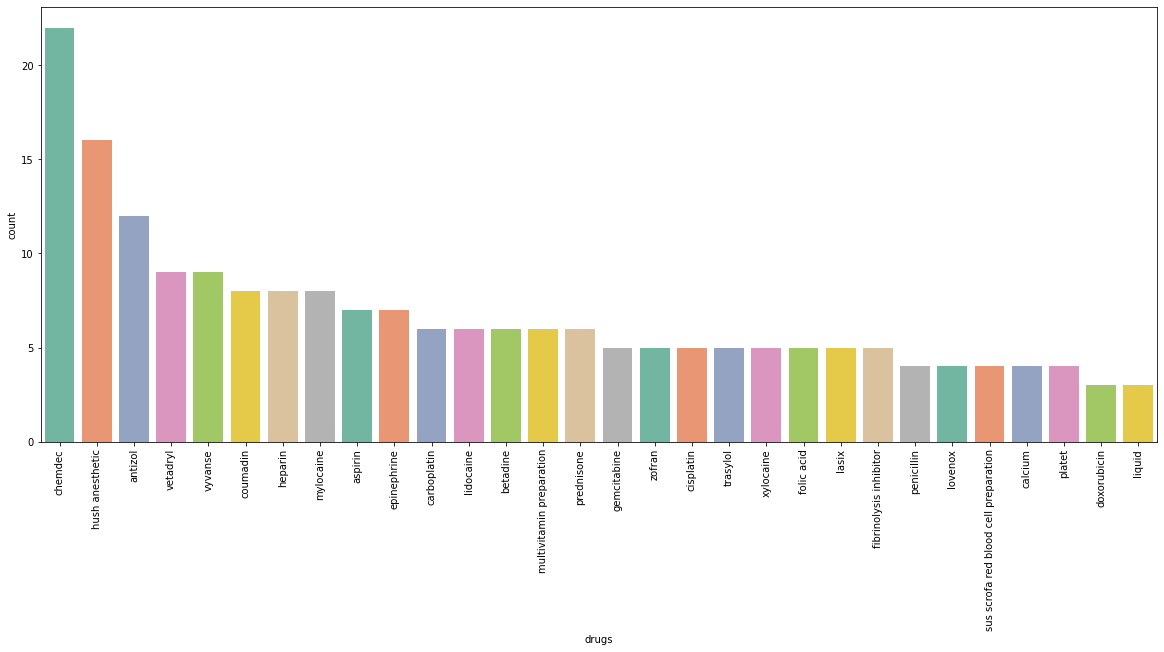

In [0]:
unique_drugs = rxnorm_res.groupby(["path","drugs"]).count().reset_index()[["path","drugs"]]	

plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

sns.countplot(unique_drugs.drugs, order=unique_drugs.drugs.value_counts().head(30).index, palette="Set2")
plt.show()

**Checking all posology entities `DRUG`, `FREQUENCY`, `DURATION`, `STRENGTH`, `FORM`, `DOSAGE` and `ROUTE` and their RXNORM Code by using `ner_posology_greedy` model without WhiteList.**

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

## to get drugs
drugs_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_drug")

drugs_ner_converter_ing = NerConverter() \
    .setInputCols(["sentence", "token", "ner_drug"]) \
    .setOutputCol("ner_chunk")
  
drugs_c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

sbert_embedder_ing = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models")\
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

pipeline_rxnorm_greedy = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        drugs_ner_greedy,
        drugs_ner_converter_ing, 
        drugs_c2doc, 
        sbert_embedder_ing,
        rxnorm_resolver])

data_ner = spark.createDataFrame([['']]).toDF("text")
rxnorm_model_greedy = pipeline_rxnorm_greedy.fit(data_ner)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[ | ][ / ][ — ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 810.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
rxnorm_code_greedy = rxnorm_model_greedy.transform(df) 

In [0]:
rxnorm_greedy_res = rxnorm_code_greedy.select("path", F.explode(F.arrays_zip( 'ner_chunk.result', 'rxnorm_code.result', 'rxnorm_code.metadata')).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("drug_chunk"),
                                            F.expr("cols['1']").alias("rxnorm_code"),
                                            F.expr("cols['2']['confidence']").alias("confidence"),
                                            F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                            F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()


codes = []
resolutions = []

for code, resolution in zip(rxnorm_greedy_res['all_codes'], rxnorm_greedy_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
rxnorm_greedy_res['all_codes'] = codes  
rxnorm_greedy_res['resolutions'] = resolutions
rxnorm_greedy_res['drugs'] = rxnorm_greedy_res['resolutions'].apply(lambda x : x[0])

In [0]:
rxnorm_greedy_res.head(40)

Out[150]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin 1 mg,438737,0.2020,"[438737, 447086, 330877, 336400, 2168762, 437893, 350284, 636675, 333663, 452857, 637189, 331499...","[coumarin 1 mg, propinox 1 mg, acenocoumarol 1 mg, ipecac 1 mg, tesamorelin 1 mg, ethacridine 1 ...",coumarin 1 mg
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,daily,216356,0.4904,"[216356, 216358, 216351, 864120, 1856425, 1166944, 151781, 540256, 1043260, 216357, 216377, 1020...","[dailyhist, dailyhist-d, daily hist, oxy daily wash, oxy daily defense, daily hist oral product,...",dailyhist
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Amiodarone 100 mg p.o,331043,0.1398,"[331043, 573992, 835955, 199597, 876015, 564695, 540542, 566587, 316329, 565346, 835957, 875937,...","[amiodarone 100 mg, amiodarone 100 mg [amidox], amiodarone hydrochloride 100 mg, amiodarone 100 ...",amiodarone 100 mg
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,daily,216356,0.4904,"[216356, 216358, 216351, 864120, 1856425, 1166944, 151781, 540256, 1043260, 216357, 216377, 1020...","[dailyhist, dailyhist-d, daily hist, oxy daily wash, oxy daily defense, daily hist oral product,...",dailyhist
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chemotherapy,215982,0.2013,"[215982, 353612, 12574, 215984, 3041, 194000, 215978, 2555, 40048, 3639, 215703, 239, 15657, 636...","[chemdec, chemocycline, gemcitabine, chemet, cytarabine, capecitabine, chemdal, cisplatin, carbo...",chemdec
6,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cisplatin 75 mg/centimeter,1424917,0.0856,"[1424917, 563200, 563198, 566457, 2049118, 1425229, 543973, 328246, 568134, 544194, 563760, 1424...","[dabrafenib 75 mg, cisplatin 25 mg [platosin], cisplatin 25 mg/ml [platinex], doxepin 75 mg [ada...",dabrafenib 75 mg
7,dbfs:/oncology_notes_mt/mt_oncology_0.txt,109 mg IV piggyback,350269,0.1283,"[350269, 350542, 349115, 1356818, 349114, 1806950, 384812, 617350, 336403, 452649, 806389, 85674...","[sodium gluconate 1090 mg, doxycycline 109 mg, doxycycline 109 mg oral capsule, polysaccharide i...",sodium gluconate 1090 mg
8,dbfs:/oncology_notes_mt/mt_oncology_0.txt,over 2 hours,546139,0.2705,"[546139, 216077, 1425414, 261537, 358690, 393180, 393037, 800205, 217678, 1243021, 882493, 11832...","[sudatuss 2 df, claritin-d 24 hour, super 2x, h 9600, sodium sulfate 2 x, oxygen 2 %, carbon dio...",sudatuss 2 df
9,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Alimta 500 mg/ centimeter squared equaling 730 mg IV piggyback,282566,0.0484,"[282566, 573118, 200003, 204577, 242666, 252092, 199219, 1144139, 209533, 213196, 566878, 900783...","[chromium 0.05 mg / garcinia cambogia preparation 500 mg oral tablet, sodium phenylbutyrate 500 ...",chromium 0.05 mg / garcinia cambogia preparation 500 mg oral tablet


**Lets check results that confidence level greater than 0.5**

In [0]:
rxnorm_greedy_res[rxnorm_greedy_res.confidence.astype(float)>0.5].head(40)

Out[151]:

,path,drug_chunk,rxnorm_code,confidence,all_codes,resolutions,drugs
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
12,dbfs:/oncology_notes_mt/mt_oncology_0.txt,heparin,5224,0.9933,"[5224, 1857598, 9877, 484060, 5228, 87866, 1857599, 1857949, 1160315, 849773, 1160317, 374387, 1...","[heparin, heparin injection, heparin sodium, heparin sodium, heparinoids, ardeparin, heparin inj...",heparin
15,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
28,dbfs:/oncology_notes_mt/mt_oncology_10.txt,Coumadin,202421,0.5329,"[202421, 2898, 1855075, 216223, 216222, 218274, 152085, 128793, 2540, 1435932, 214904, 225235, 2...","[coumadin, coumarin, coumaran, coricidin d, coricidin, medcodin, mycifradin, vicodin, cilastatin...",coumadin
29,dbfs:/oncology_notes_mt/mt_oncology_10.txt,Lasix,202991,0.5872,"[202991, 151963, 2256930, 1043720, 224946, 217961, 365206, 218014, 203783, 261550, 1013021, 6066...","[lasix, lasma, lasmiditan, lidoworx, lidex, laniroif, lasix syrup, lidex-e, lanoxicaps, lanabiot...",lasix
30,dbfs:/oncology_notes_mt/mt_oncology_10.txt,metformin,6809,0.9913,"[6809, 1161611, 152161, 1161610, 406082, 8129, 235743, 1161609, 1182890, 1182891, 372803, 29648,...","[metformin, metformin pill, orabet metformin, metformin oral product, metformin oral solution, p...",metformin
31,dbfs:/oncology_notes_mt/mt_oncology_10.txt,folic acid,4511,0.9852,"[4511, 861537, 1162058, 1162059, 62356, 372260, 542060, 619039, 385103, 1162057, 1162056, 226933...","[folic acid, hematinic with folic acid, folic acid oral product, folic acid pill, folate, folic ...",folic acid
32,dbfs:/oncology_notes_mt/mt_oncology_10.txt,diltiazem,3443,0.9712,"[3443, 1791228, 1151888, 81999, 543413, 484943, 314592, 203211, 1151889, 1151887, 376886, 393149...","[diltiazem, diltiazem injection, diltiazem oral product, diltiazem malate, dilitiazem, diltiazem...",diltiazem
37,dbfs:/oncology_notes_mt/mt_oncology_10.txt,iron,90176,0.9889,"[90176, 217791, 486120, 217789, 218794, 218420, 1368648, 217103, 217106, 217790, 220414, 541234,...","[iron, ironmar, iron fumarate, iron sol, nu-iron, mol-iron, ferulate, ferralet, ferrimin, iron s...",iron
38,dbfs:/oncology_notes_mt/mt_oncology_10.txt,folic acid,4511,0.9852,"[4511, 861537, 1162058, 1162059, 62356, 372260, 542060, 619039, 385103, 1162057, 1162056, 226933...","[folic acid, hematinic with folic acid, folic acid oral product, folic acid pill, folate, folic ...",folic acid


As you can see some of the drug entities RXNORM code changed when control them by using greedy algorithm. For example it could find RXNORM Code of `folic acid 0.8 mg` now.

**Visualize Greedy Algorithm Entities**

In [0]:
sample_text = df.limit(1).select("text").collect()[0]

print(sample_text)

Row(text='Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.\nPAST MEDICAL HISTORY\n1. Pericardectomy.\n2. Pericarditis.\n2. Atrial fibrillation.\n4. RNCA with intracranial thrombolytic treatment.\n5 PTA of MCA.\n6. Mesenteric venous thrombosis.\n7. Pericardial window.\n8. Cholecystectomy.\n9. Left thoracentesis.\nFAMILY HISTORY:\nNo family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.\nSOCIAL HISTORY:\nShe is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.\nMEDICATIONS\n1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.\n2. Amiodarone 100 mg p.o. daily.\nREVIEW OF SYSTEMS:\nComplete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.\nPHYSICAL EXAMINATION\nVITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.\nGENERAL: Positive nonproductive cough and pain with coughing.\nHEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.\nNECK: Supple. No lymphadenopathy. No masses.\nRESPIRATORY: Pleural friction rub is noted.\nGI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.\nEXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.\nSKIN: No breakdown or lesions. No ulcers.\nNEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.\nLABORATORY DATA:\nLabs are pending.\nHOSPITAL COURSE:\nThe patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid bio

In [0]:
light_model =  LightPipeline(rxnorm_model)

ann_text = light_model.fullAnnotate(sample_text)[0]
print(ann_text.keys())

dict_keys(['document', 'ner_chunk', 'sentence_embeddings', 'token', 'rxnorm_code', 'ner_drug', 'embeddings', 'ner_chunk_doc', 'sentence'])

In [0]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of DRUG entity label
visualiser.set_label_colors({'DRUG':'#008080', })
ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin DRUG 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone DRUG 100 mg p.o. daily. REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox DRUG 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which reve

**So, if you want to find just the posology entities in greedy form, here is the pipeline you can use.**

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")
posology_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[ | ][OK!]

In [0]:
sample_text = df.limit(1).select("text").collect()[0]

print(sample_text)

Row(text='Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion.\nPAST MEDICAL HISTORY\n1. Pericardectomy.\n2. Pericarditis.\n2. Atrial fibrillation.\n4. RNCA with intracranial thrombolytic treatment.\n5 PTA of MCA.\n6. Mesenteric venous thrombosis.\n7. Pericardial window.\n8. Cholecystectomy.\n9. Left thoracentesis.\nFAMILY HISTORY:\nNo family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.\nSOCIAL HISTORY:\nShe is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use.\nMEDICATIONS\n1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.\n2. Amiodarone 100 mg p.o. daily.\nREVIEW OF SYSTEMS:\nComplete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.\nPHYSICAL EXAMINATION\nVITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.\nGENERAL: Positive nonproductive cough and pain with coughing.\nHEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.\nNECK: Supple. No lymphadenopathy. No masses.\nRESPIRATORY: Pleural friction rub is noted.\nGI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.\nEXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.\nSKIN: No breakdown or lesions. No ulcers.\nNEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.\nLABORATORY DATA:\nLabs are pending.\nHOSPITAL COURSE:\nThe patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid bio

In [0]:
light_model =  LightPipeline(posology_model)
light_result = light_model.fullAnnotate(sample_text)[0]

In [0]:
#Creating the vizualizer 
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
# visualiser.set_label_colors({'DRUG':'#008080'})
ner_vis = visualiser.display(light_result, label_col='ner_chunk_greedy',return_html=True)

#Displaying the vizualizer 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma - 1 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. FAMILY HISTORY: No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer. SOCIAL HISTORY: She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco, alcohol or illicit drug use. MEDICATIONS 1. Coumadin 1 mg DRUG daily FREQUENCY . Last INR was on Tuesday, August 14, 2007, and her INR was 2.3. 2. Amiodarone 100 mg p.o DRUG . daily FREQUENCY . REVIEW OF SYSTEMS: Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm. PHYSICAL EXAMINATION VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%. GENERAL: Positive nonproductive cough and pain with coughing. HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear. NECK: Supple. No lymphadenopathy. No masses. RESPIRATORY: Pleural friction rub is noted. GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly. EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities. SKIN: No breakdown or lesions. No ulcers. NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Labs are pending. HOSPITAL COURSE: The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin DRUG was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were per

# 3. Get Timeline Using RE Models

We will create a relation extration model to identify temporal relationships among clinical events by using pretrained **RelationExtractionModel** `re_temporal_events_clinical`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencerDL_hc = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

events_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner_tags")  

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel.pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = Pipeline(stages=[
  documentAssembler,
  sentencerDL_hc,
  tokenizer, 
  word_embeddings, 
  pos_tagger, 
  events_ner_tagger,
  ner_chunker,
  dependency_parser,
  clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][ / ][OK!]
ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
[ | ][ / ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ][ / ][OK!]

**Selecting the columns we need and transforming to Pandas Dataframe.**

In [0]:
temporal_re_df = model.transform(df)

In [0]:
temporal_re_pd_df = temporal_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['0']").alias("relation"),
                                          F.expr("cols['1']['entity1']").alias('entity1'),
                                          F.expr("cols['1']['chunk1']").alias('chunk1'),
                                          F.expr("cols['1']['entity2']").alias('entity2'),
                                          F.expr("cols['1']['chunk2']").alias('chunk2'),
                                          F.expr("cols['1']['confidence']").alias('confidence')
                                         ).toPandas()

In [0]:
temporal_re_pd_df.head(40)

Out[249]:

,path,relation,entity1,chunk1,entity2,chunk2,confidence
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,BEFORE,OCCURRENCE,Discharge,PROBLEM,Mesothelioma,0.99999833
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,Mesothelioma,PROBLEM,pleural effusion,1.0
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,Mesothelioma,PROBLEM,atrial fibrillation,0.99999607
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,Mesothelioma,PROBLEM,anemia,0.9996013
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,Mesothelioma,PROBLEM,ascites,0.99999917
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,Mesothelioma,PROBLEM,esophageal reflux,0.9999963
6,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,pleural effusion,PROBLEM,atrial fibrillation,1.0
7,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,pleural effusion,PROBLEM,anemia,1.0
8,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,pleural effusion,PROBLEM,ascites,1.0
9,dbfs:/oncology_notes_mt/mt_oncology_0.txt,OVERLAP,PROBLEM,pleural effusion,PROBLEM,esophageal reflux,0.94568694


## 3.1. Find the problems occured after treatments 

We are filtering the dataframe to select rows with following conditions to see problems occured after treatments.
* `relation =='AFTER'`
* `entity1=='TREATMENT'`
* `entity2=='PROBLEM'`

In [0]:
temporal_re_pd_df[(temporal_re_pd_df.relation =='AFTER') & (temporal_re_pd_df.entity1=='TREATMENT') & (temporal_re_pd_df.entity2=='PROBLEM')]

Out[250]:

,path,relation,entity1,chunk1,entity2,chunk2,confidence
561,dbfs:/oncology_notes_mt/mt_oncology_14.txt,AFTER,TREATMENT,this procedure,PROBLEM,complications,0.97644377
1339,dbfs:/oncology_notes_mt/mt_oncology_20.txt,AFTER,TREATMENT,intravenous heparin,PROBLEM,hereditary hypercoagulable state,0.9599375
1422,dbfs:/oncology_notes_mt/mt_oncology_21.txt,AFTER,TREATMENT,Xylocaine,PROBLEM,a transverse incision,0.9999807
1424,dbfs:/oncology_notes_mt/mt_oncology_21.txt,AFTER,TREATMENT,epinephrine,PROBLEM,a transverse incision,0.9999982
2811,dbfs:/oncology_notes_mt/mt_oncology_37.txt,AFTER,TREATMENT,hemostatic,PROBLEM,a skin stab inferior,0.95746464
3326,dbfs:/oncology_notes_mt/mt_oncology_40.txt,AFTER,TREATMENT,Implant,PROBLEM,ruptured,0.9999635
6483,dbfs:/oncology_notes_mt/mt_oncology_72.txt,AFTER,TREATMENT,BEAM regimen,PROBLEM,relapse,0.9916402
6488,dbfs:/oncology_notes_mt/mt_oncology_72.txt,AFTER,TREATMENT,BEAM regimen,PROBLEM,relapse,0.94857323
7918,dbfs:/oncology_notes_mt/mt_oncology_87.txt,AFTER,TREATMENT,a surgical,PROBLEM,her elevated PT/INR,0.999532


# 4. Analyze the Relations Between Body Parts and Procedures

We will create a relation extration model to identify relationships between body parts and problem entities by using pretrained **RelationExtractionModel** `re_bodypart_problem`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencerDL_hc = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel() \
    .pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_tags")

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner_tags"]) \
    .setOutputCol("ner_chunks_re")\
    .setWhiteList(['Internal_organ_or_component', 'Problem', 'Procedure'])

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["sentence", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

re_model = RelationExtractionModel()\
    .pretrained('re_bodypart_problem', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks_re", "dependencies"]) \
    .setOutputCol("relations")

bodypart_re_pipeline = Pipeline(stages=[documentAssembler, 
                            sentencerDL_hc, 
                            tokenizer, 
                            pos_tagger, 
                            word_embeddings, 
                            ner_tagger, 
                            ner_converter,
                            dependency_parser,
                            #re_ner_chunk_filter, 
                            re_model])


empty_data = spark.createDataFrame([['']]).toDF("text")
bodypart_re_model = bodypart_re_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][ — ][OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ][OK!]
re_bodypart_problem download started this may take some time.
Approximate size to download 9.2 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]

In [0]:
bodypart_re_df = bodypart_re_model.transform(df)

In [0]:
bodypart_relation = bodypart_re_df.select("path", F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols"))\
                                  .select("path",
                                          F.expr("cols['0']").alias("relation"),
                                          F.expr("cols['1']['entity1']").alias('entity1'),
                                          F.expr("cols['1']['chunk1']").alias('chunk1'),
                                          F.expr("cols['1']['entity2']").alias('entity2'),
                                          F.expr("cols['1']['chunk2']").alias('chunk2'),
                                          F.expr("cols['1']['confidence']").alias('confidence')
                                          ).toPandas()

## 4.1. Extract internal bodypart and procedure relations

We are filtering the dataframe to select rows with following conditions to see the relations between different entities.
* `entity1 != entity2'`

In [0]:
bodypart_relation = bodypart_relation[bodypart_relation.entity1!=bodypart_relation.entity2].iloc[:,:-1].drop_duplicates()
bodypart_relation

Out[167]:

,path,relation,entity1,chunk1,entity2,chunk2
32,dbfs:/oncology_notes_mt/mt_oncology_10.txt,1,Procedure,Biopsy,Internal_organ_or_component,Cervical Lymph Node
33,dbfs:/oncology_notes_mt/mt_oncology_10.txt,1,Procedure,Excisional biopsy,Internal_organ_or_component,cervical lymph node
35,dbfs:/oncology_notes_mt/mt_oncology_10.txt,1,Procedure,excisional biopsy,Internal_organ_or_component,cervical lymph node
39,dbfs:/oncology_notes_mt/mt_oncology_12.txt,1,Internal_organ_or_component,axillary lymph node,Procedure,excisional biopsy
50,dbfs:/oncology_notes_mt/mt_oncology_15.txt,0,Internal_organ_or_component,parathyroid,Procedure,removal of this parathyroid adenoma
51,dbfs:/oncology_notes_mt/mt_oncology_15.txt,0,Internal_organ_or_component,blood,Procedure,removal of this parathyroid adenoma
52,dbfs:/oncology_notes_mt/mt_oncology_15.txt,0,Procedure,total abdominal hysterectomy/bilateral salpingo-oophorectomy,Internal_organ_or_component,vaginal cuff
54,dbfs:/oncology_notes_mt/mt_oncology_15.txt,1,Internal_organ_or_component,adrenal gland,Procedure,gross total resection
55,dbfs:/oncology_notes_mt/mt_oncology_15.txt,1,Internal_organ_or_component,adrenal gland,Procedure,biopsied
63,dbfs:/oncology_notes_mt/mt_oncology_15.txt,1,Procedure,fine needle aspiration,Internal_organ_or_component,mandible


**We can see the procedures applied to internal organs**

# 5. Get Procedure codes from notes

We will create a new pipeline to get procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical` and setting NerConverter's WhiteList `['Procedure']` in order to get only drug entities.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

proc_ner = MedicalNerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_proc")

proc_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner_proc"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['Procedure'])

proc_c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

proc_sbert_embedder = BertSentenceEmbeddings\
    .pretrained("sbiobert_base_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")

cpt_resolver = SentenceEntityResolverModel.pretrained("demo_sbiobertresolve_cpt","en", "clinical/models")\
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")

bert_pipeline_cpt = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        proc_ner,
        proc_ner_converter, 
        proc_c2doc, 
        proc_sbert_embedder,
        cpt_resolver])
empty_data = spark.createDataFrame([['']]).toDF("text")
cpt_model = bert_pipeline_cpt.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][ / ][ — ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]
demo_sbiobertresolve_cpt download started this may take some time.
Approximate size to download 3.1 MB
[ | ][OK!]

In [0]:
cpt_model_res = cpt_model.transform(df)

In [0]:
cpt_res = cpt_model_res.select("path", F.explode(F.arrays_zip( 'ner_chunk.result', 'ner_chunk.metadata', 'cpt_code.result', 'cpt_code.metadata')).alias("cols"))\
                          .select("path", F.expr("cols['0']").alias("chunks"),
                                          F.expr("cols['1']['entity']").alias("entity"),
                                          F.expr("cols['2']").alias("cpt_code"),
                                          F.expr("cols['3']['confidence']").alias("confidence"),
                                          F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                          F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(cpt_res['all_codes'], cpt_res['resolutions']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    
  
cpt_res['all_codes'] = codes  
cpt_res['resolutions'] = resolutions
cpt_res['cpt'] = cpt_res['resolutions'].apply(lambda x : x[0])

In [0]:
cpt_res.head()

Out[184]:

,path,chunks,entity,cpt_code,confidence,all_codes,resolutions,cpt
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,decortication of the lung,Procedure,32100,0.1184,"[32100, 31592, 32440, 39200, 32220, 32225, 32651, 32151, 32320, 32110, 32445, 50280, 60280, 6474...","[Thoracotomy; with exploration, Cricotracheal resection, Removal of lung, pneumonectomy;, Resect...",Thoracotomy; with exploration
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,pleural biopsy,Procedure,32609,0.8109,"[32609, 32607, 32608, 32100, 32124, 32096, 32320, 32097, 32960, 32310, 39200, 32151, 32200, 3265...","[Thoracoscopy; with biopsy(ies) of pleura, Thoracoscopy; with diagnostic biopsy(ies) of lung inf...",Thoracoscopy; with biopsy(ies) of pleura
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,thoracentesis,Procedure,32100,0.2843,"[32100, 60500, 25927, 19316, 39200, 32609, 60505, 49426, 62223, 60280, 32960, 61304, 64746, 3954...","[Thoracotomy; with exploration, Parathyroidectomy or exploration of parathyroid(s), Transmetacar...",Thoracotomy; with exploration
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Port-A-Cath placement,Procedure,50290,0.0735,"[50290, 33722, 49426, 49419, 33020, 47610, 62225, 47715, 33404, 43800, 44650, 60500, 62194, 6222...","[Excision of perinephric cyst , Closure of aortico-left ventricular tunnel , Revision of peri...",Excision of perinephric cyst
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,pericardectomy,Procedure,32320,0.2040,"[32320, 32310, 61305, 32100, 32440, 31420, 33050, 32445, 31592, 47600, 33020, 61524, 44950, 3137...","[Decortication and parietal pleurectomy, Pleurectomy, parietal (separate procedure), Craniectomy...",Decortication and parietal pleurectomy


## 5.1. See most common procedures being performed

Let's count the number of each procedures and plot it.

In [0]:
#top 20
cpt_res['cpt'].value_counts().reset_index().head(20)

Out[185]:

,index,cpt
0,Appendectomy,58
1,Thoracoscopy; with biopsy(ies) of pleura,52
2,Excision of presacral or sacrococcygeal tumor,29
3,Thoracotomy; with exploration,26
4,Resection of mediastinal tumor,17
5,Epiglottidectomy,13
6,Revision of peritoneal-venous shunt,12
7,Cervical lymphadenectomy (modified radical neck dissection),11
8,Excision of perinephric cyst,10
9,"Closure of enterostomy, large or small intestine",9


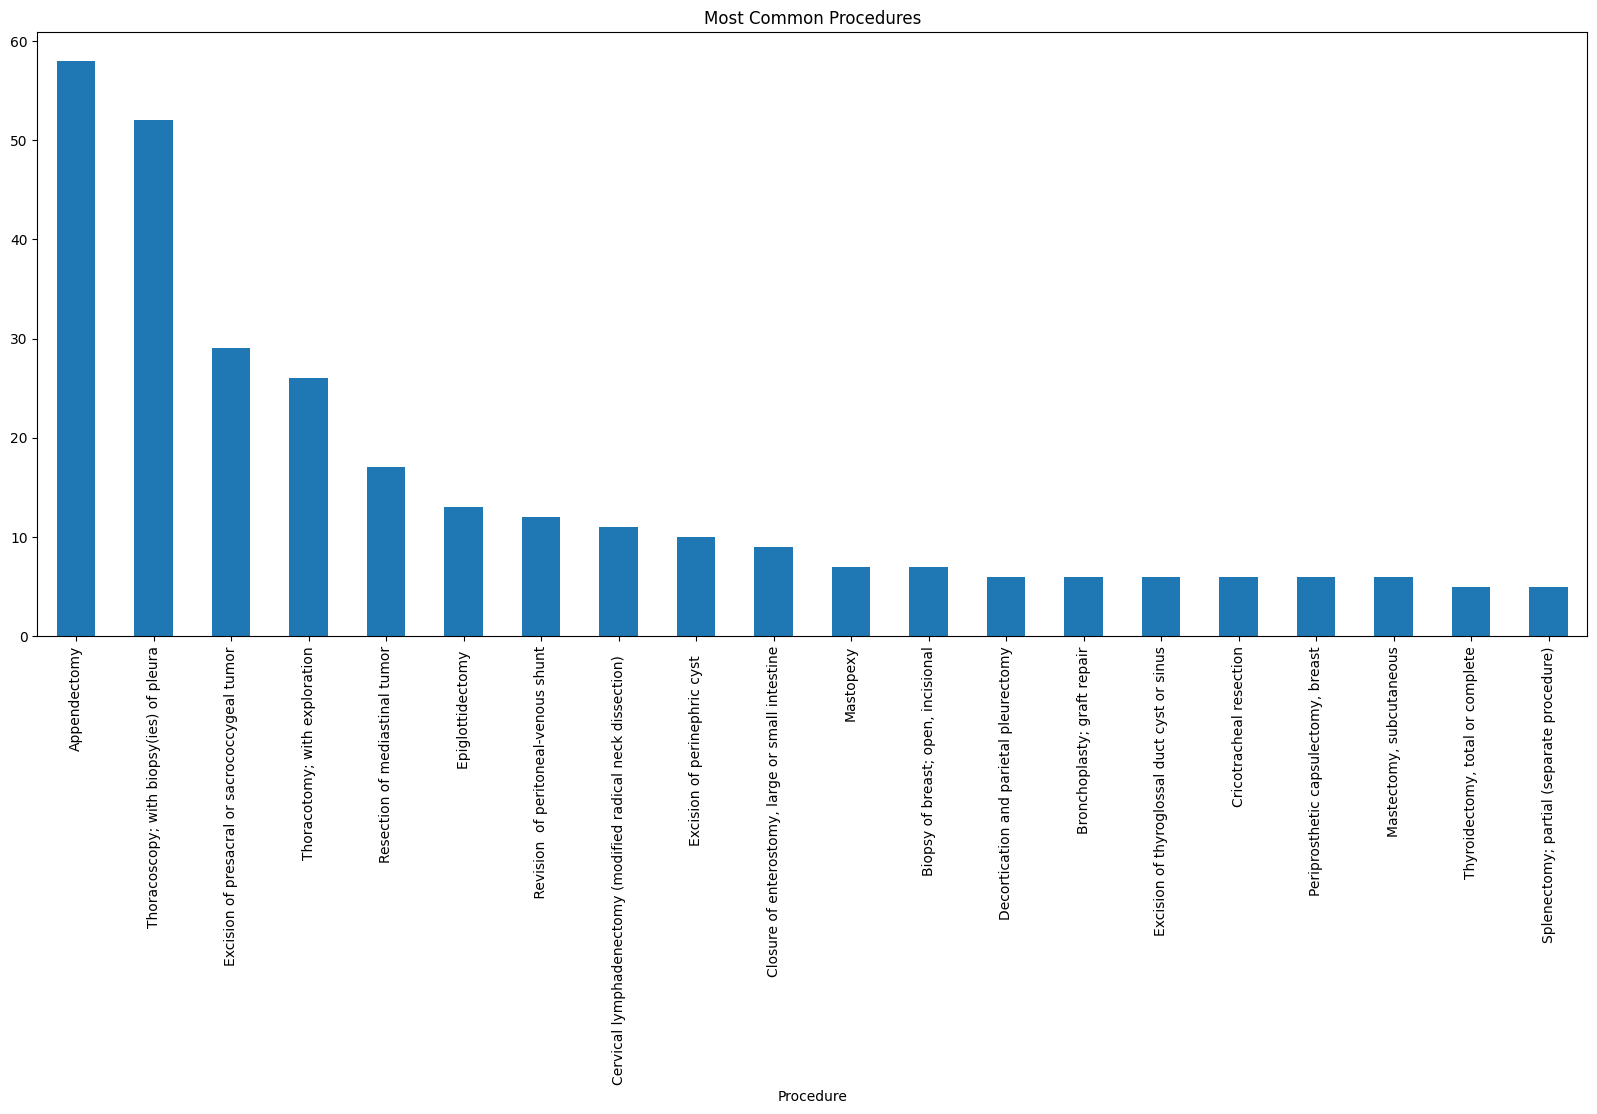

In [0]:
plt.figure(figsize=(20,8),dpi=100)
cpt_res['cpt'].value_counts().head(20).plot.bar()
plt.title('Most Common Procedures')
plt.xlabel("Procedure")
plt.show()

# 6. Get Assertion Status of Cancer Entities

We will create a new pipeline to get assertion status of cancer entities procedure codes. As NER model, we are using `jsl_ner_wip_greedy_clinical`.

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("bionlp_ner")

bionlp_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "bionlp_ner"]) \
    .setOutputCol("bionlp_ner_chunk")\
    .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("jsl_ner_wip_greedy_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Oncological", "Symptom"])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('bionlp_ner_chunk', "jsl_ner_chunk")\
    .setOutputCol('final_ner_chunk')

cancer_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "final_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")


assertion_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        bionlp_ner,
        bionlp_ner_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        cancer_assertion
    ])
empty_data = spark.createDataFrame([['']]).toDF("text")
assertion_model = assertion_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[ | ][OK!]
jsl_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[ | ][OK!]

In [0]:
assertion_res = assertion_model.transform(df)

In [0]:
assertion_df = assertion_res.select("path", F.explode(F.arrays_zip('final_ner_chunk.result', 'final_ner_chunk.metadata', 'assertion.result')).alias("cols"))\
                            .select("path", F.expr("cols['0']").alias("chunk"),
                                            F.expr("cols['1']['entity']").alias("entity"),
                                            F.expr("cols['2']").alias("assertion")).toPandas()

In [0]:
assertion_df.head(20)

Out[194]:

,path,chunk,entity,assertion
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Mesothelioma,Oncological,present
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Mesothelioma,Oncological,present
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,Mesothelioma,Oncological,present
3,dbfs:/oncology_notes_mt/mt_oncology_0.txt,nonproductive cough,Symptom,present
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chest pain,Symptom,present
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cough,Symptom,present
6,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chest pain,Symptom,present
7,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cancer,Cancer,associated_with_someone_else
8,dbfs:/oncology_notes_mt/mt_oncology_0.txt,occasional numbness,Symptom,present
9,dbfs:/oncology_notes_mt/mt_oncology_0.txt,tingling of her left arm,Symptom,present


**We can find the number of family members of cancer patients with cancer or symptoms**

In [0]:
print("Number of family members have cancer or symptoms: ", len(assertion_df[assertion_df.assertion=="associated_with_someone_else"]))

Number of family members have cancer or symptoms: 63

### 6.1 Use Case: Finding assertion status of the most common symptoms 

We will check if the symptom is absent or present.

In [0]:
assertion_df = assertion_df.drop_duplicates()
assertion_symptom = assertion_df[(assertion_df.assertion.isin(['present', 'absent'])) & (assertion_df.entity=="Symptom")]
most_common_symptoms = assertion_symptom.groupby(['path', 'assertion', 'chunk']).count().reset_index().chunk.value_counts().index[:20]

In [0]:
assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)]

Out[197]:

,path,chunk,entity,assertion
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chest pain,Symptom,present
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cough,Symptom,present
11,dbfs:/oncology_notes_mt/mt_oncology_0.txt,pain,Symptom,present
13,dbfs:/oncology_notes_mt/mt_oncology_0.txt,lymphadenopathy,Symptom,absent
14,dbfs:/oncology_notes_mt/mt_oncology_0.txt,masses,Symptom,absent
...,...,...,...,...
2185,dbfs:/oncology_notes_mt/mt_oncology_9.txt,vomiting,Symptom,absent
2193,dbfs:/oncology_notes_mt/mt_oncology_9.txt,murmurs,Symptom,absent
2194,dbfs:/oncology_notes_mt/mt_oncology_9.txt,gallops,Symptom,absent
2202,dbfs:/oncology_notes_mt/mt_oncology_9.txt,hepatosplenomegaly,Symptom,absent


In [0]:
assertion_df["assertion"].value_counts()

Out[198]: present 945
absent 709
possible 75
associated_with_someone_else 51
hypothetical 27
conditional 17
Name: assertion, dtype: int64

In [0]:
 assertion_df.groupby(["path","assertion"]).count().reset_index()

Out[199]:

,path,assertion,chunk,entity
0,dbfs:/oncology_notes_mt/mt_oncology_0.txt,absent,12,12
1,dbfs:/oncology_notes_mt/mt_oncology_0.txt,associated_with_someone_else,1,1
2,dbfs:/oncology_notes_mt/mt_oncology_0.txt,present,18,18
3,dbfs:/oncology_notes_mt/mt_oncology_1.txt,absent,1,1
4,dbfs:/oncology_notes_mt/mt_oncology_1.txt,present,7,7
...,...,...,...,...
232,dbfs:/oncology_notes_mt/mt_oncology_89.txt,hypothetical,1,1
233,dbfs:/oncology_notes_mt/mt_oncology_89.txt,present,19,19
234,dbfs:/oncology_notes_mt/mt_oncology_9.txt,absent,42,42
235,dbfs:/oncology_notes_mt/mt_oncology_9.txt,associated_with_someone_else,2,2


In [0]:
assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)]

Out[200]:

,path,chunk,entity,assertion
4,dbfs:/oncology_notes_mt/mt_oncology_0.txt,chest pain,Symptom,present
5,dbfs:/oncology_notes_mt/mt_oncology_0.txt,cough,Symptom,present
11,dbfs:/oncology_notes_mt/mt_oncology_0.txt,pain,Symptom,present
13,dbfs:/oncology_notes_mt/mt_oncology_0.txt,lymphadenopathy,Symptom,absent
14,dbfs:/oncology_notes_mt/mt_oncology_0.txt,masses,Symptom,absent
...,...,...,...,...
2185,dbfs:/oncology_notes_mt/mt_oncology_9.txt,vomiting,Symptom,absent
2193,dbfs:/oncology_notes_mt/mt_oncology_9.txt,murmurs,Symptom,absent
2194,dbfs:/oncology_notes_mt/mt_oncology_9.txt,gallops,Symptom,absent
2202,dbfs:/oncology_notes_mt/mt_oncology_9.txt,hepatosplenomegaly,Symptom,absent


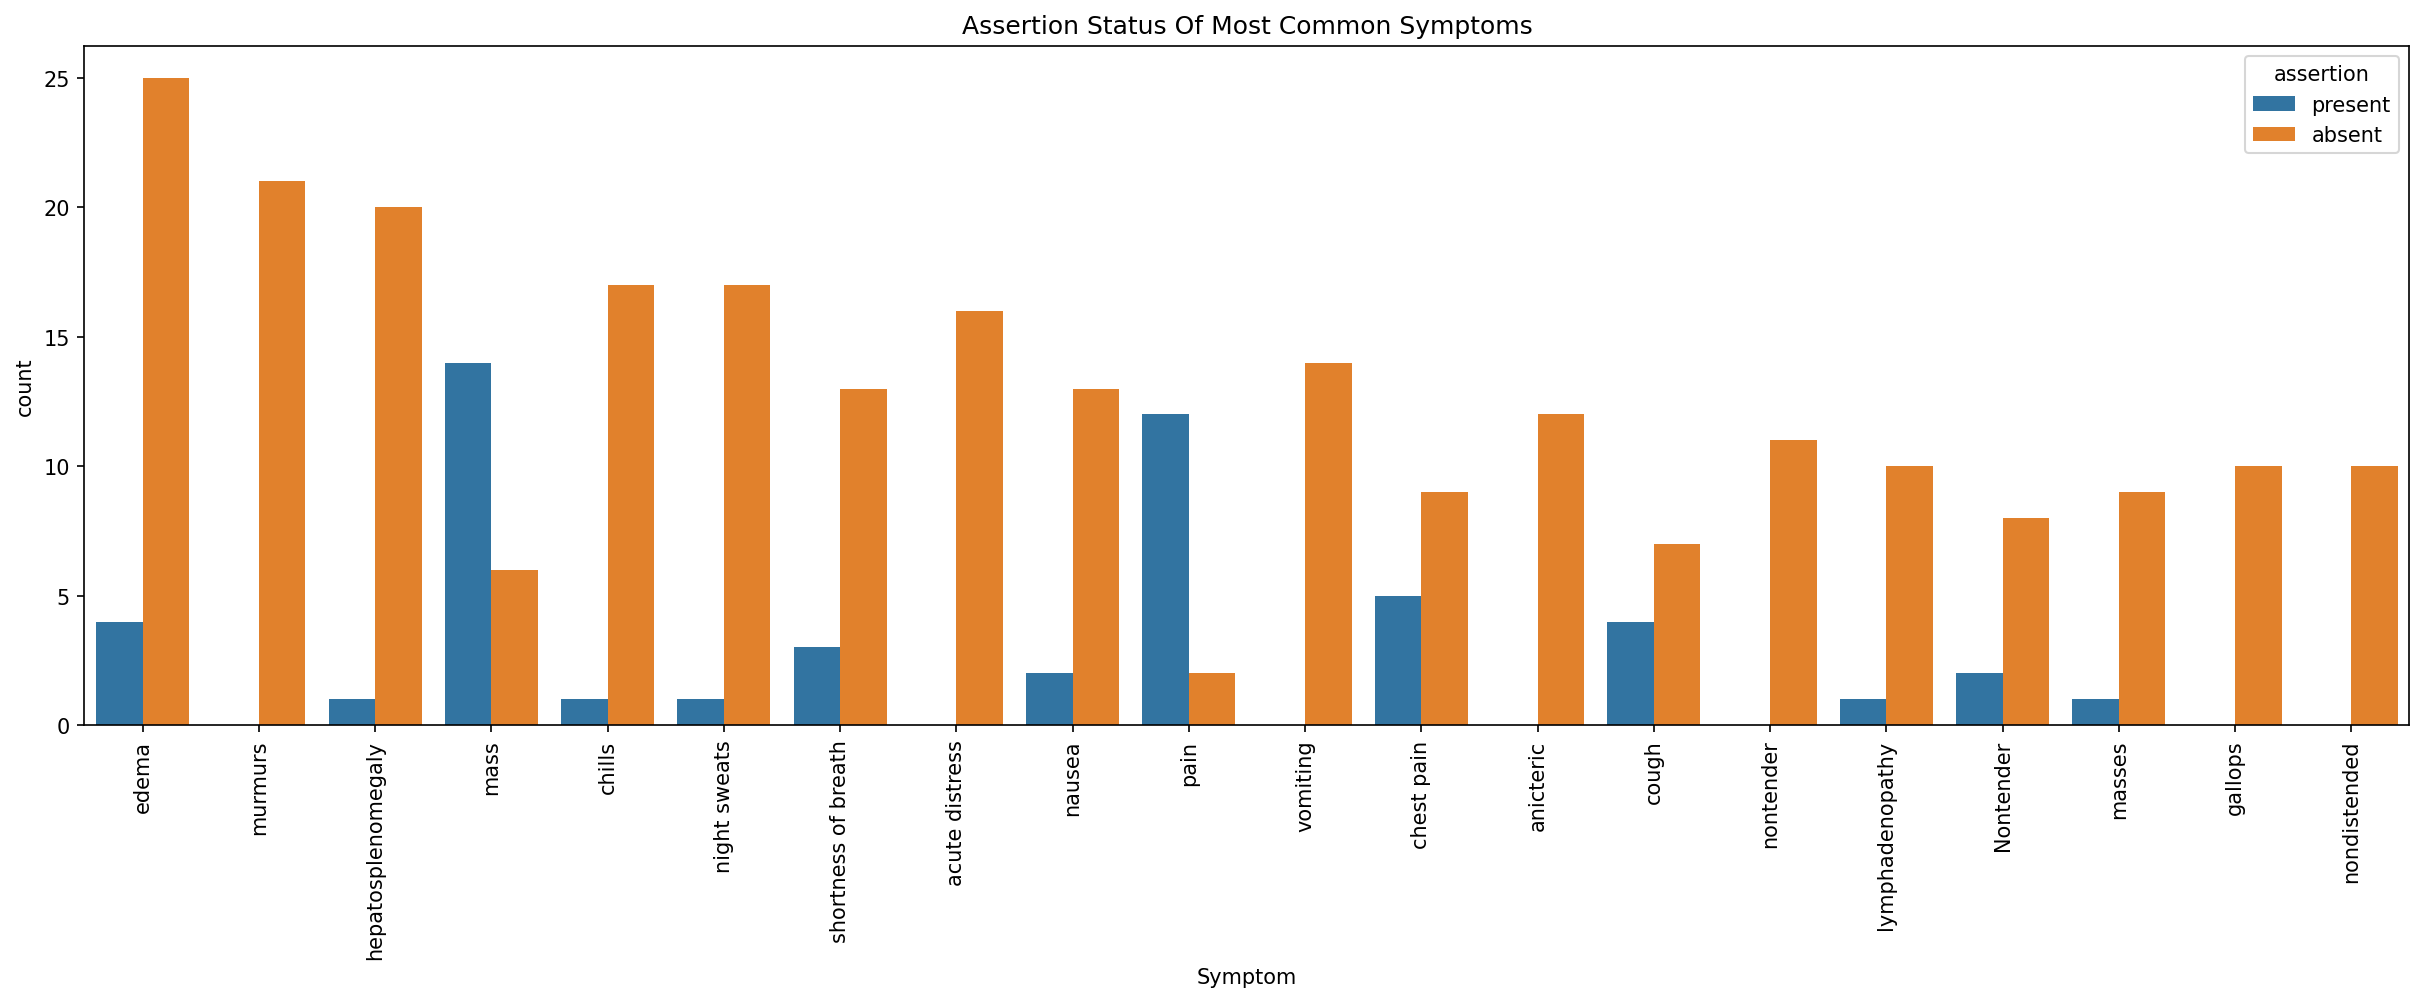

In [0]:
plt.figure(figsize=(20,6), dpi=150)
sns.countplot(x='chunk', data=assertion_symptom[assertion_symptom.chunk.isin(most_common_symptoms)], hue='assertion', order=most_common_symptoms )
plt.xticks(rotation = 90)
plt.title("Assertion Status Of Most Common Symptoms")
plt.xlabel("Symptom")
plt.show()

**End Of Notebook**